<div class="alert alert-info">
My awesome notebook for muon $p_{\mathrm{T}}$ regression.
</div>

In [1]:
from nn_globals import *

from nn_encode import (nlayers, nvariables, create_encoder)

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (save_my_model, load_my_model, update_keras_custom_objects,
                       save_my_history, load_my_history,
                       create_model_bn2, lr_decay, reduce_lr)

from nn_training import train_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


### Parameters

In [2]:
# Train a new model or use an existing model
do_training = False

# Specify inputs for the training
# - default: muon gun with a uniform distribution in 1/pT, eta, phi (pT>2, 1.2<|eta|<2.5)
# - run2   : default minus Phase-2 trigger primitives
# - omtf   : muon gun in the overlap region (pT>3, 0.8<|eta|<1.4)
# - displ  : displaced muons with 0<|d0|<120 cm
# - mixing : tracks from MinBias PU200 events
# - collus : tracks from SingleMu+PU200 events
# - augmnt : tracks from SingleMu with augmentation (disabled stations)
run2_input = False

omtf_input = False

displ_input = True

mixing_input = True

collus_input = True

augmnt_input = True

# Training parameters
model_name = 'model16'

nodes = [30,25,20]

learning_rate = 0.01

gradient_clip_norm = 1.

epochs = 200

batch_size = 2048

# ______________________________________________________________________________
if run2_input:
  from nn_encode_run3 import (nlayers, nvariables, create_encoder)
  infile_muon = infile_muon_run3
  infile_pileup = infile_pileup_run3
  
  model_name = 'model_run3'
  
  epochs = 300

# ______________________________________________________________________________
if omtf_input:
  from nn_encode_omtf import (nlayers, nvariables, create_encoder)
  infile_muon = infile_muon_omtf
  infile_pileup = infile_pileup_omtf
  
  model_name = 'model_omtf'
  
  epochs = 450

# ______________________________________________________________________________
# Freeze function keywords
from functools import partial

create_encoder_1 = partial(create_encoder,
                           reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)

In [3]:
#FIXME
infile_pileup = '../test7/histos_tbd_alt.27.npz'

### Import data

In [4]:
# Import muon data
# 'x' is the array of input variables, 'y' is muon q/pT

test_size = 0.3

x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
    muon_data_split(infile_muon, create_encoder=create_encoder_1, test_size=test_size, no_warn=False)

[INFO    ] Loading muon data from ../test7/histos_tba.27.npz ...
[INFO    ] Loaded the variables with shape (3319149, 164)
[INFO    ] Loaded the parameters with shape (3319149, 6)
[INFO    ] Loaded the encoded variables with shape (3319149, 36)
[INFO    ] Loaded the encoded parameters with shape (3319149,)
[INFO    ] Loaded # of training and testing events: (2323404, 995745)


In [5]:
# Import pileup data
# 'x' is the array of input variables, 'aux' is pileup info (jobid, ievt, highest_part_pt, highest_track_pt)

test_job = 159

pu_x_train, pu_x_test, pu_y_train, pu_y_test, pu_dxy_train, pu_dxy_test, pu_dz_train, pu_dz_test, pu_x_mask_train, pu_x_mask_test, pu_x_road_train, pu_x_road_test, pu_aux_train, pu_aux_test = \
    pileup_data_split(infile_pileup, create_encoder=create_encoder_1, test_job=test_job)

[INFO    ] Loading pileup data from ../test7/histos_tbd_alt.27.npz ...
[INFO    ] Loaded the variables with shape (2403889, 164)
[INFO    ] Loaded the auxiliary PU info with shape (2403889, 4)
[INFO    ] Loaded the encoded variables with shape (2403889, 36)
[INFO    ] Loaded the encoded parameters with shape (2403889,)
[INFO    ] Loaded the encoded auxiliary PU info with shape (2403889, 4)
[INFO    ] Loaded # of training and testing events (PU): (2212997, 190892)


In [6]:
# Import highpt data
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3

highpt_x_train, highpt_x_test, highpt_y_train, highpt_y_test, highpt_dxy_train, highpt_dxy_test, highpt_dz_train, highpt_dz_test, highpt_x_mask_train, highpt_x_mask_test, highpt_x_road_train, highpt_x_road_test = \
    muon_data_split(infile_highpt, create_encoder=create_encoder_1, test_size=test_size, no_warn=True)

[INFO    ] Loading muon data from ../test7/histos_tbe.27.npz ...
[INFO    ] Loaded the variables with shape (215816, 164)
[INFO    ] Loaded the parameters with shape (215816, 6)
[INFO    ] Loaded the encoded variables with shape (215816, 36)
[INFO    ] Loaded the encoded parameters with shape (215816,)
[INFO    ] Loaded # of training and testing events: (151071, 64745)


In [7]:
# Import displ muon data (1)
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3

displ1_x_train, displ1_x_test, displ1_y_train, displ1_y_test, displ1_dxy_train, displ1_dxy_test, displ1_dz_train, displ1_dz_test, displ1_x_mask_train, displ1_x_mask_test, displ1_x_road_train, displ1_x_road_test = \
    muon_data_split(infile_displ1, create_encoder=create_encoder_1, test_size=test_size, no_warn=True)

[INFO    ] Loading muon data from ../test7/histos_tba_displ1.27.npz ...
[INFO    ] Loaded the variables with shape (1105260, 164)
[INFO    ] Loaded the parameters with shape (1105260, 6)
[INFO    ] Loaded the encoded variables with shape (1105260, 36)
[INFO    ] Loaded the encoded parameters with shape (1105260,)
[INFO    ] Loaded # of training and testing events: (773682, 331578)


In [8]:
# Import displ muon data (2)
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3

displ2_x_train, displ2_x_test, displ2_y_train, displ2_y_test, displ2_dxy_train, displ2_dxy_test, displ2_dz_train, displ2_dz_test, displ2_x_mask_train, displ2_x_mask_test, displ2_x_road_train, displ2_x_road_test = \
    muon_data_split(infile_displ2, create_encoder=create_encoder_1, test_size=test_size, no_warn=True)

[INFO    ] Loading muon data from ../test7/histos_tba_displ2.27.npz ...
[INFO    ] Loaded the variables with shape (969134, 164)
[INFO    ] Loaded the parameters with shape (969134, 6)
[INFO    ] Loaded the encoded variables with shape (969134, 36)
[INFO    ] Loaded the encoded parameters with shape (969134,)
[INFO    ] Loaded # of training and testing events: (678393, 290741)


In [9]:
#FIXME
# Take absolute values

y_train = np.abs(y_train)
y_test = np.abs(y_test)
pu_y_train = np.abs(pu_y_train)
pu_y_test = np.abs(pu_y_test)
highpt_y_train = np.abs(highpt_y_train)
highpt_y_test = np.abs(highpt_y_test)
displ1_y_train = np.abs(displ1_y_train)
displ1_y_test = np.abs(displ1_y_test)
displ2_y_train = np.abs(displ2_y_train)
displ2_y_test = np.abs(displ2_y_test)

In [10]:
# Add 'classes' output node, and stack all the output nodes

class Masks:
  '''Dummy class'''
  pass

def define_mask_values():
  '''Define mask values for classes

  90 - Prompt muons
  80 - Displaced muons
  20 - PU tracks with matched TP
  10 - PU tracks without matched TP
   0 - default
  '''
  MASKS = Masks()
  MASKS.prompt = 90
  MASKS.displ = 80
  MASKS.pileup = 20
  MASKS.pileupx = 10
  return MASKS

MASKS = define_mask_values()

y_train_stack = np.full(y_train.shape, MASKS.prompt, dtype=np.float32)
y_train_stack = np.column_stack((y_train, y_train, dxy_train, y_train_stack))

pu_y_train_stack = np.full(pu_y_train.shape, MASKS.pileup, dtype=np.float32)
pu_y_train_stack[(pu_y_train == 0) | (np.abs(pu_y_train) > 0.5 * reg_pt_scale)] = MASKS.pileupx
pu_y_train_stack[(np.abs(pu_dxy_train) > 3. * reg_dxy_scale)] = MASKS.pileupx
pu_y_train_stack = np.column_stack((pu_y_train, pu_y_train, pu_dxy_train, pu_y_train_stack))

highpt_y_train_stack = np.full(highpt_y_train.shape, MASKS.prompt, dtype=np.float32)
highpt_y_train_stack = np.column_stack((highpt_y_train, highpt_y_train, highpt_dxy_train, highpt_y_train_stack))

displ1_y_train_stack = np.full(displ1_y_train.shape, MASKS.displ, dtype=np.float32)
displ1_y_train_stack = np.column_stack((displ1_y_train, displ1_y_train, displ1_dxy_train, displ1_y_train_stack))

displ2_y_train_stack = np.full(displ2_y_train.shape, MASKS.displ, dtype=np.float32)
displ2_y_train_stack = np.column_stack((displ2_y_train, displ2_y_train, displ2_dxy_train, displ2_y_train_stack))

logger.info('Dataset 0: {0} class: {1}'.format((x_train.shape, y_train_stack.shape), np.squeeze(y_train_stack[..., 3:4])))
logger.info('Dataset 1: {0} class: {1}'.format((pu_x_train.shape, pu_y_train_stack.shape), np.squeeze(pu_y_train_stack[..., 3:4])))
logger.info('Dataset 2: {0} class: {1}'.format((highpt_x_train.shape, highpt_y_train_stack.shape), np.squeeze(highpt_y_train_stack[..., 3:4])))
logger.info('Dataset 3: {0} class: {1}'.format((displ1_x_train.shape, displ1_y_train_stack.shape), np.squeeze(displ1_y_train_stack[..., 3:4])))
logger.info('Dataset 4: {0} class: {1}'.format((displ2_x_train.shape, displ2_y_train_stack.shape), np.squeeze(displ2_y_train_stack[..., 3:4])))

[INFO    ] Dataset 0: ((2323404, 36), (2323404, 4)) class: [90. 90. 90. ... 90. 90. 90.]
[INFO    ] Dataset 1: ((2212997, 36), (2212997, 4)) class: [10. 10. 10. ... 10. 20. 20.]
[INFO    ] Dataset 2: ((151071, 36), (151071, 4)) class: [90. 90. 90. ... 90. 90. 90.]
[INFO    ] Dataset 3: ((773682, 36), (773682, 4)) class: [80. 80. 80. ... 80. 80. 80.]
[INFO    ] Dataset 4: ((678393, 36), (678393, 4)) class: [80. 80. 80. ... 80. 80. 80.]


In [11]:
# Merge the final training data, and prepare validation data

validation_split = 0.1

def training_slice(x):
  split_at = int(int(x.shape[0]) * (1. - validation_split))
  return x[0:split_at]

def validation_slice(x):
  split_at = int(int(x.shape[0]) * (1. - validation_split))
  return x[split_at:]

def _128_slice(x):
  split_at = x.shape[0] - (x.shape[0] % 128)
  return x[0:split_at]

if do_training:
  x_train_new = np.concatenate((
      training_slice(x_train),
      training_slice(pu_x_train),  # artificially increase PU stats
      training_slice(pu_x_train),  # artificially increase PU stats
      #training_slice(pu_x_train),  # artificially increase PU stats
      #training_slice(pu_x_train),  # artificially increase PU stats
      training_slice(highpt_x_train),
      training_slice(displ1_x_train),
      training_slice(displ2_x_train),
  ))
  x_train_new = _128_slice(x_train_new)

  y_train_new = np.concatenate((
      training_slice(y_train_stack),
      training_slice(pu_y_train_stack),  # artificially increase PU stats
      training_slice(pu_y_train_stack),  # artificially increase PU stats
      #training_slice(pu_y_train_stack),  # artificially increase PU stats
      #training_slice(pu_y_train_stack),  # artificially increase PU stats
      training_slice(highpt_y_train_stack),
      training_slice(displ1_y_train_stack),
      training_slice(displ2_y_train_stack),
  ))
  y_train_new = _128_slice(y_train_new)

  val_x_train_new = np.concatenate((
      validation_slice(x_train),
      validation_slice(pu_x_train),  # artificially increase PU stats
      validation_slice(pu_x_train),  # artificially increase PU stats
      #validation_slice(pu_x_train),  # artificially increase PU stats
      #validation_slice(pu_x_train),  # artificially increase PU stats
      validation_slice(highpt_x_train),
      validation_slice(displ1_x_train),
      validation_slice(displ2_x_train),
  ))
  val_x_train_new = _128_slice(val_x_train_new)

  val_y_train_new = np.concatenate((
      validation_slice(y_train_stack),
      validation_slice(pu_y_train_stack),  # artificially increase PU stats
      validation_slice(pu_y_train_stack),  # artificially increase PU stats
      #validation_slice(pu_y_train_stack),  # artificially increase PU stats
      #validation_slice(pu_y_train_stack),  # artificially increase PU stats
      validation_slice(highpt_y_train_stack),
      validation_slice(displ1_y_train_stack),
      validation_slice(displ2_y_train_stack),
  ))
  val_y_train_new = _128_slice(val_y_train_new)

  # Shuffle validation data
  num_val_samples = val_x_train_new.shape[0]
  val_index_array = np.arange(num_val_samples)
  np.random.shuffle(val_index_array)
  val_x_train_new = val_x_train_new[val_index_array]
  val_y_train_new = val_y_train_new[val_index_array]

  logger.info('Final dataset: {0} validation: {1}'.format((x_train_new.shape, y_train_new.shape), (val_x_train_new.shape, val_y_train_new.shape)))

### Training

In [12]:
#FIXME
from nn_models import (Sequential, Dense, BatchNormalization, Activation,
                       regularizers, optimizers)

from tensorflow.python.ops.distributions import special_math

class LossFunction(object):
  """Abstract loss function base class"""

  def __init__(self):
    pass

  def loss_fn(self, y_true, y_pred):
    raise NotImplementedError

class EMLF(LossFunction):
  """Endcap muon loss function

  This complicated loss function is written to optimize 3 parameters of interest
  at the same time:
  - vertex-constraint pT
  - vertex-unconstraint pT
  - transverse impact parameter, d0

  The relative weights of the loss functions for the 3 parameters are adjusted
  by the kappa terms.
  """

  def __init__(self, reg_pt_scale=100., reg_dxy_scale=0.4,
               kappa_lp0 = 1.0, 
               kappa_lpq0 = 0.02,
               kappa_lppu0 = 0.2,
               kappa_lp1 = 0.2,
               kappa_lpq1 = 0.2 * 0.02,
               kappa_lppu1 = 0.2 * 0.2,
               kappa_lp2 = 0.2,
               kappa_lpq2 = 0.2 * 0.02,
               kappa_lppu2 = 0.2 * 0.2):
    super(EMLF, self).__init__()
    self.reg_pt_scale = reg_pt_scale
    self.reg_dxy_scale = reg_dxy_scale

    with K.name_scope(self.__class__.__name__):
      self.iterations = K.variable(0, dtype='int64', name='iterations')
      self.kappa_lp0 = K.variable(kappa_lp0, name='kappa_lp0')
      self.kappa_lpq0 = K.variable(kappa_lpq0, name='kappa_lpq0')
      self.kappa_lppu0 = K.variable(kappa_lppu0, name='kappa_lppu0')
      self.kappa_lp1 = K.variable(kappa_lp1, name='kappa_lp1')
      self.kappa_lpq1 = K.variable(kappa_lpq1, name='kappa_lpq1')
      self.kappa_lppu1 = K.variable(kappa_lppu1, name='kappa_lppu1')
      self.kappa_lp2 = K.variable(kappa_lp2, name='kappa_lp2')
      self.kappa_lpq2 = K.variable(kappa_lpq2, name='kappa_lpq2')
      self.kappa_lppu2 = K.variable(kappa_lppu2, name='kappa_lppu2')

  def loss_fn(self, y_true, y_pred):  # override
    l, _ = self.loss_fn_with_components(y_true, y_pred)
    return l

  def loss_fn_with_components(self, y_true, y_pred):

    def _cast(x):
      x = K.cast(x, dtype=K.floatx())
      return x

    def _weighted_cast(x):
      x = K.cast(x, dtype=K.floatx())
      x /= (K.mean(x) + K.epsilon())
      return x

    def _log_prob_normal(x, loc, scale):
      # Log probability for Normal, see:
      #   https://en.wikipedia.org/wiki/Normal_distribution
      #   https://github.com/tensorflow/probability/blob/v0.6.0/tensorflow_probability/python/distributions/normal.py
      standardize = lambda x: (x - loc) / scale
      log_prob = -(0.5 * K.square(standardize(x)) +
                   0.5 * np.log(2. * np.pi) +
                   K.log(scale))
      return log_prob

    def _log_prob_truncated_normal(x, loc, scale, low, high):
      # Log probability for Truncated Normal, see:
      #   https://en.wikipedia.org/wiki/Truncated_normal_distribution
      #   https://github.com/tensorflow/probability/blob/v0.6.0/tensorflow_probability/python/distributions/truncated_normal.py
      standardize = lambda x: (x - loc) / scale
      tiny = np.float32(1e-15)
      eps = np.finfo(np.float32).eps
      log_prob_normalizer = (special_math.ndtr(standardize(high)) -
                             special_math.ndtr(standardize(low)))
      log_prob_normalizer = tf.clip_by_value(log_prob_normalizer, tiny, 1. - eps)
      log_prob = -(0.5 * K.square(standardize(x)) +
                   0.5 * np.log(2. * np.pi) +
                   K.log(scale * log_prob_normalizer))
      return log_prob

    def _log_prob_huber_normal(x, loc, scale):
      # Normal, but replacing the famous square function by pseudo-huber loss function
      #   https://en.wikipedia.org/wiki/Huber_loss#Pseudo-Huber_loss_function
      standardize = lambda x: (x - loc) / scale
      log_prob = -(1.0 * (K.sqrt(K.square(standardize(x)) + 1) - 1) +
                   0.5 * np.log(2. * np.pi) + np.log(1.3054616) +
                   K.log(scale))
      return log_prob

    # __________________________________________________________________________
    t = y_pred
    u = y_true

    _ones = K.ones_like(t[..., 0:1], dtype=K.floatx())
    
    # Classes
    masks_prompt = K.equal(u[..., 3:4], MASKS.prompt)
    masks_displ = K.equal(u[..., 3:4], MASKS.displ)
    masks_pileup = K.equal(u[..., 3:4], MASKS.pileup)
    masks_pileupx = K.equal(u[..., 3:4], MASKS.pileupx)

    # Par 0: vertex-constrained pT
    low0 = 0.0 * self.reg_pt_scale   # infinite
    high0 = 0.5 * self.reg_pt_scale  # 2 GeV
    init0 = np.log(np.expm1(high0))  # shifted to 2 GeV

    y_true0 = K.abs(u[..., 0:1])
    y_true0 = tf.clip_by_value(y_true0, low0, high0)
    y_true0 = tf.where(masks_pileupx, high0 * _ones, y_true0)  # overwrite 'pileupx' with 2 GeV
    q_true0 = u[..., 0:1]
    q_true0 = tf.clip_by_value(q_true0, -high0, high0)

    y_pred0 = t[..., 0:1] + init0
    q_pred0 = t[..., 1:2]
    scale0 = 1e-5 + tf.nn.softplus(0.01 * t[..., 2:3])

    # Par 1: vertex-unconstrained pT
    low1 = 0.0 * self.reg_pt_scale   # infinite
    high1 = 0.5 * self.reg_pt_scale  # 2 GeV
    init1 = np.log(np.expm1(high1))  # shifted to 2 GeV

    y_true1 = K.abs(u[..., 1:2])
    y_true1 = tf.clip_by_value(y_true1, low1, high1)
    y_true1 = tf.where(masks_pileupx, high1 * _ones, y_true1)  # overwrite 'pileupx' with 2 GeV
    q_true1 = u[..., 1:2]
    q_true1 = tf.clip_by_value(q_true1, -high1, high1)

    y_pred1 = t[..., 3:4] + init1
    q_pred1 = t[..., 4:5]
    scale1 = 1e-5 + tf.nn.softplus(0.01 * t[..., 5:6])

    # Par 2: transverse impact parameter, d0
    low2 = 0. * self.reg_dxy_scale     # 0 cm
    high2 = 100. * self.reg_dxy_scale  # 100 cm
    init2 = 0.                         # no shift

    y_true2 = K.abs(u[..., 2:3])
    y_true2 = tf.clip_by_value(y_true2, low2, high2)
    y_true2 = tf.where(masks_pileupx, low2 * _ones, y_true2)  # overwrite 'pileupx' with 0 cm
    q_true2 = u[..., 2:3]
    q_true2 = tf.clip_by_value(q_true2, -high2, high2)

    y_pred2 = t[..., 6:7] + init2
    q_pred2 = t[..., 7:8]
    scale2 = 1e-5 + tf.nn.softplus(0.01 * t[..., 8:9])

    # Log probs
    #log_prob0 = _log_prob_normal(y_true0, y_pred0, scale0)
    #log_prob0 = _log_prob_truncated_normal(y_true0, y_pred0, scale0, low0, high0)
    log_prob0 = _log_prob_huber_normal(y_true0, y_pred0, scale0)
    log_prob_q0 = _log_prob_huber_normal(q_true0, q_pred0, scale0)
    log_prob_pu0 = log_prob0

    log_prob1 = _log_prob_huber_normal(y_true1, y_pred1, scale1)
    log_prob_q1 = _log_prob_huber_normal(q_true1, q_pred1, scale1)
    log_prob_pu1 = log_prob1

    log_prob2 = _log_prob_huber_normal(y_true2, y_pred2, scale2)
    log_prob_q2 = _log_prob_huber_normal(q_true2, q_pred2, scale2)
    log_prob_pu2 = log_prob2

    # Masks
    masks_lp0 = _weighted_cast(masks_prompt) * self.kappa_lp0
    masks_lpq0 = _weighted_cast(masks_prompt) * self.kappa_lpq0
    masks_lppu0 = _weighted_cast(masks_pileup | masks_pileupx) * self.kappa_lppu0

    masks_lp1 = _weighted_cast(masks_displ) * self.kappa_lp1
    masks_lpq1 = _weighted_cast(masks_displ) * self.kappa_lpq1
    masks_lppu1 = _weighted_cast(masks_pileup | masks_pileupx) * self.kappa_lppu1

    masks_lp2 = _weighted_cast(masks_displ) * self.kappa_lp2
    masks_lpq2 = _weighted_cast(masks_displ) * self.kappa_lpq2
    masks_lppu2 = _weighted_cast(masks_pileup | masks_pileupx) * self.kappa_lppu2

    # __________________________________________________________________________
    # Loss (i.e. negative log probs)
    #loss = -(log_prob0 * masks_lp0 + log_prob0 * masks_lppu0)
    #loss = -(log_prob1 * masks_lp1 + log_prob1 * masks_lppu1)
    #loss = -(log_prob2 * masks_lp2 + log_prob2 * masks_lppu2)
    loss = -(log_prob0 * masks_lp0 + log_prob0 * masks_lppu0 +
             log_prob1 * masks_lp1 + log_prob1 * masks_lppu1 +
             log_prob2 * masks_lp2 + log_prob2 * masks_lppu2)
    loss = K.mean(loss, axis=-1)

    # Components
    components = (y_true0, log_prob0, masks_lp0, log_prob_q0, masks_lpq0, log_prob_pu0, masks_lppu0,
                  y_true1, log_prob1, masks_lp1, log_prob_q1, masks_lpq1, log_prob_pu1, masks_lppu1,
                  y_true2, log_prob2, masks_lp2, log_prob_q2, masks_lpq2, log_prob_pu2, masks_lppu2)
    return loss, components

def create_model_sequential_emlf(nodes1=30, nodes2=25, nodes3=20, 
                                 nodesIn=36, nodesOut=1, emlf=None):
  """Create a Sequential model for a dense NN with 3 hidden layers."""

  model = Sequential([
    # BN layer right after the input layer
    BatchNormalization(input_shape=(nodesIn,), epsilon=1e-4, momentum=0.9),
    # Hidden layer 1
    Dense(nodes1, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
    BatchNormalization(epsilon=1e-4, momentum=0.9),
    Activation('relu'),
    # Hidden layer 2
    Dense(nodes2, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
    BatchNormalization(epsilon=1e-4, momentum=0.9),
    Activation('relu'),
    # Hidden layer 3
    Dense(nodes3, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
    BatchNormalization(epsilon=1e-4, momentum=0.9),
    Activation('relu'),
    # Output layer
    Dense(nodesOut, kernel_initializer='zeros', use_bias=True, activation=None),
  ])

  # Attach emlf to model
  model.emlf = emlf

  # Set loss and optimizer
  adam = optimizers.Adam(lr=learning_rate, clipnorm=gradient_clip_norm)
  model.compile(optimizer=adam, loss=model.emlf.loss_fn)
  return model

In [13]:
# Fit

if do_training:
  assert(K.backend() == 'tensorflow')

  # Create model
  emlf = EMLF(reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)
  model = create_model_sequential_emlf(nodes1=nodes[0], nodes2=nodes[1], nodes3=nodes[2],
                                       nodesIn=nvariables, nodesOut=9, emlf=emlf)
  model.summary()

  # Start training
  #history = model.fit(x_train, y_train_stack,
  #                    validation_split=validation_split,
  #                    callbacks=[reduce_lr,],
  #                    epochs=epochs, batch_size=batch_size, verbose=1)

  #history = model.fit(np.concatenate((x_train, pu_x_train, pu_x_train)),
  #                    np.concatenate((y_train_stack, pu_y_train_stack, pu_y_train_stack)),
  #                    validation_split=validation_split,
  #                    callbacks=[reduce_lr,],
  #                    epochs=epochs, batch_size=batch_size, verbose=1)

  #history = model.fit(np.concatenate((displ1_x_train, displ2_x_train, pu_x_train, pu_x_train)),
  #                    np.concatenate((displ1_y_train_stack, displ2_y_train_stack, pu_y_train_stack, pu_y_train_stack)),
  #                    validation_split=validation_split,
  #                    callbacks=[reduce_lr,],
  #                    epochs=epochs, batch_size=batch_size, verbose=1)

  history = model.fit(x_train_new, y_train_new,
                      validation_data=(val_x_train_new, val_y_train_new),
                      callbacks=[reduce_lr,],
                      epochs=epochs, batch_size=batch_size, verbose=1)

  # Save model & training history
  save_my_model(model, name=model_name)
  save_my_history(history.history, name=model_name)

### Regression Results

In [14]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, separation_score, find_efficiency_errors, \
                         np_printoptions)

from sklearn.metrics import (mean_squared_error, mean_absolute_error, median_absolute_error, \
                             roc_curve, roc_auc_score, log_loss)

from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)
my_palette = ('#377eb8', '#e41a1c', '#984ea3', '#ff7f00', '#4daf4a', '#bfbf33', '#a65628', '#f781bf')

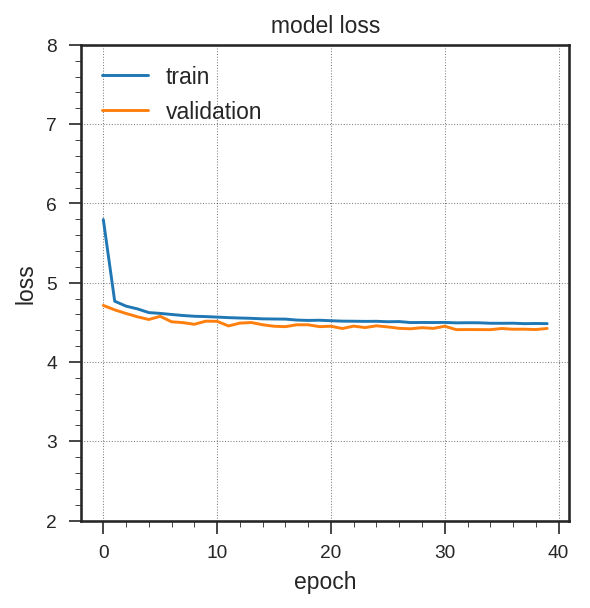

[INFO    ] Epoch 40/40 - loss: 4.4834223779 - val_loss: 4.42270850558


In [15]:
# Plot loss vs epoch
history = load_my_history(name=model_name)

plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(2,8)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

metrics = [len(history['loss']), history['loss'][-1], history['val_loss'][-1]]
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

In [16]:
# Load model and predict outputs
update_keras_custom_objects()
loaded_model = load_my_model(name=model_name+'.json', weights_name=model_name+'_weights.h5')
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//8

def np_relu(x):
  # ReLu(x) = max(0, x)
  return x * (x >= 0.)

def np_softplus(x):
  # Softplus f(x) = log(1+exp(x))
  return np_relu(x) + np.log1p(np.exp(-np.abs(x)))

def np_sigmoid(x):
  # Sigmoid f(x) = 1/(1+exp(-x))
  # It is related to tanh, which is safer to call.
  return 0.5 * (1. + np.tanh(0.5*x))

def np_normal_cdf(x):
  return 0.5 * (1. + scipy.special.erf(x/np.sqrt(2.)))

def get_loc(loc):
  c = np.log(np.expm1(0.5 * reg_pt_scale))  # shifted to 2 GeV
  loc = loc + c
  loc = np.clip(loc, 1./500 * reg_pt_scale, np.inf)
  return loc

def get_loc_dxy(loc):
  loc = np.clip(loc, 0., np.inf)
  return loc

def get_sign(sign):
  return (sign >= 0.0) * 2. - 1.

def get_scale(scale):
  return 1e-5 + np_softplus(0.01 * scale)

def get_discr(loc, scale):
  if True:  #FIXME
    return (loc * 0) + 1
  standardize = lambda x: (x - loc) / scale
  low = 0.0 * reg_pt_scale   # infinite pT
  high = 0.5 * reg_pt_scale  # 2 GeV
  #cut = 0.25 * reg_pt_scale  # 4 GeV
  cut = 0.125 * reg_pt_scale  # 8 GeV
  loc = np.abs(loc)
  loc = np.clip(loc, low, high)
  #
  tiny = np.float32(1e-15)
  eps = np.finfo(np.float32).eps
  normalizer = np_normal_cdf(standardize(high)) - np_normal_cdf(standardize(low))
  normalizer = np.clip(normalizer, tiny, 1. - eps)
  prob = (np_normal_cdf(standardize(cut)) - np_normal_cdf(standardize(low))) / normalizer
  prob = np.clip(prob, tiny, 1. - eps)
  return prob

def get_true_y(x):
  out = x.copy()
  out = np.abs(out)  #FIXME
  out /= reg_pt_scale
  if out.ndim == 1:
    out = out[:, np.newaxis]
  return out

def get_true_dxy(x):
  out = x.copy()
  out = np.abs(out)  #FIXME
  out /= reg_dxy_scale
  if out.ndim == 1:
    out = out[:, np.newaxis]
  return out

def get_regr_y(x):
  out = x
  out /= reg_pt_scale
  return out

def get_regr_dxy(x):
  out = x
  out /= reg_dxy_scale
  return out

In [17]:
# Prepare y_test_true, y_test_pred
y_test_true = get_true_y(y_test[:nentries_test])
y_test_pred = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
y_test_pred_loc, y_test_pred_sign, y_test_pred_scale = get_loc(y_test_pred[..., 0:1]), get_sign(y_test_pred[..., 1:2]), get_scale(y_test_pred[..., 2:3])
y_test_pred_scale_logit = y_test_pred[..., 2:3]
y_test_pred_regr = get_regr_y(y_test_pred_loc)
y_test_pred_discr = get_discr(y_test_pred_loc, y_test_pred_scale)
#print y_test_true.shape, y_test_true
#print y_test_pred.shape, y_test_pred

In [18]:
# Prepare pu_y_test_true, pu_y_test_pred
pu_y_test_true = get_true_y(pu_y_test)
pu_y_test_pred = loaded_model.predict(pu_x_test, batch_size=4096)
pu_y_test_pred_loc, pu_y_test_pred_sign, pu_y_test_pred_scale = get_loc(pu_y_test_pred[..., 0:1]), get_sign(pu_y_test_pred[..., 1:2]), get_scale(pu_y_test_pred[..., 2:3])
pu_y_test_pred_regr = get_regr_y(pu_y_test_pred_loc)
pu_y_test_pred_discr = get_discr(pu_y_test_pred_loc, pu_y_test_pred_scale)
#print pu_y_test_true.shape, pu_y_test_true
#print pu_y_test_pred.shape, pu_y_test_pred

[INFO    ] # of entries: 124468, mean: 1.922562e-03, std: 3.801890e-02, mse: 1.532142e-03, mae: 2.557536e-02, mad: 2.441844e-02
[INFO    ] gaus fit (a, mu, sig): 1.024630e+04, 2.182428e-03, 2.093539e-02
[INFO    ] # of entries: 20086, mean: 5.240295e-03, std: 1.267762e-02, mse: 7.294255e-04, mae: 1.042680e-02, mad: 8.115938e-03
[INFO    ] gaus fit (a, mu, sig): 1.684929e+03, 1.510259e-03, 7.005135e-03
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


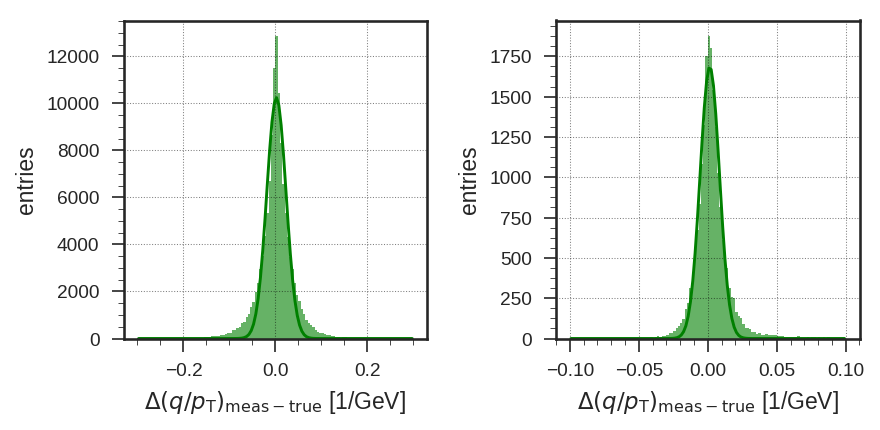

In [19]:
# Plot Delta(q/pT)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = y_test_true
yb = y_test_pred_regr
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')
axs[0].set_ylabel(r'entries')

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=120, range=(-0.3/3,0.3/3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3/3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3/3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')
axs[1].set_ylabel(r'entries')

plt.show()

[INFO    ] # of entries: 124468, mean: 4.242585e-03, std: 2.109271e-01, mse: 1.595165e-01, mae: 1.475991e-01, mad: 1.389756e-01
[INFO    ] gaus fit (a, mu, sig): 9.042251e+03, -1.796962e-02, 1.243732e-01
[INFO    ] # of entries: 20086, mean: -3.916100e-02, std: 3.440224e-01, mse: 3.202351e-01, mae: 2.716794e-01, mad: 2.590660e-01
[INFO    ] gaus fit (a, mu, sig): 8.334639e+02, -6.178145e-02, 2.077729e-01


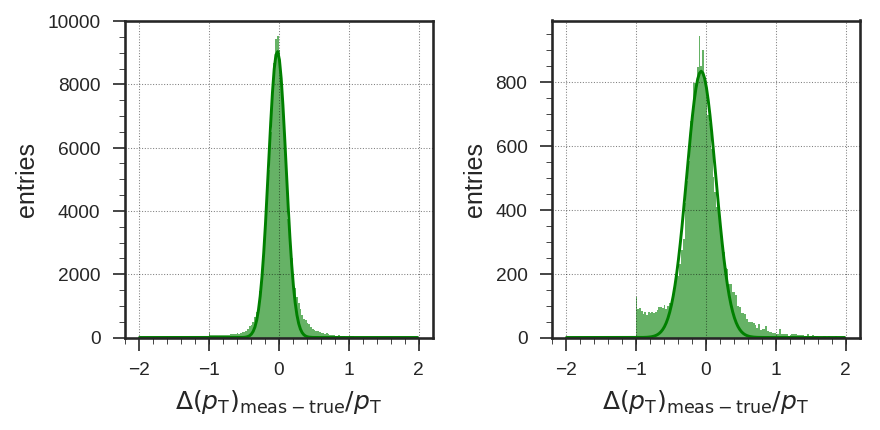

In [20]:
# Plot Delta(q/pT) / pT
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(y_test_true/y_test_true)
yb = np.abs(y_test_true/y_test_pred_regr)
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<1.5]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$', fontsize=12)
axs[0].set_ylabel(r'entries', fontsize=12)

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<1.5]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$', fontsize=12)
axs[1].set_ylabel(r'entries', fontsize=12)

plt.show()

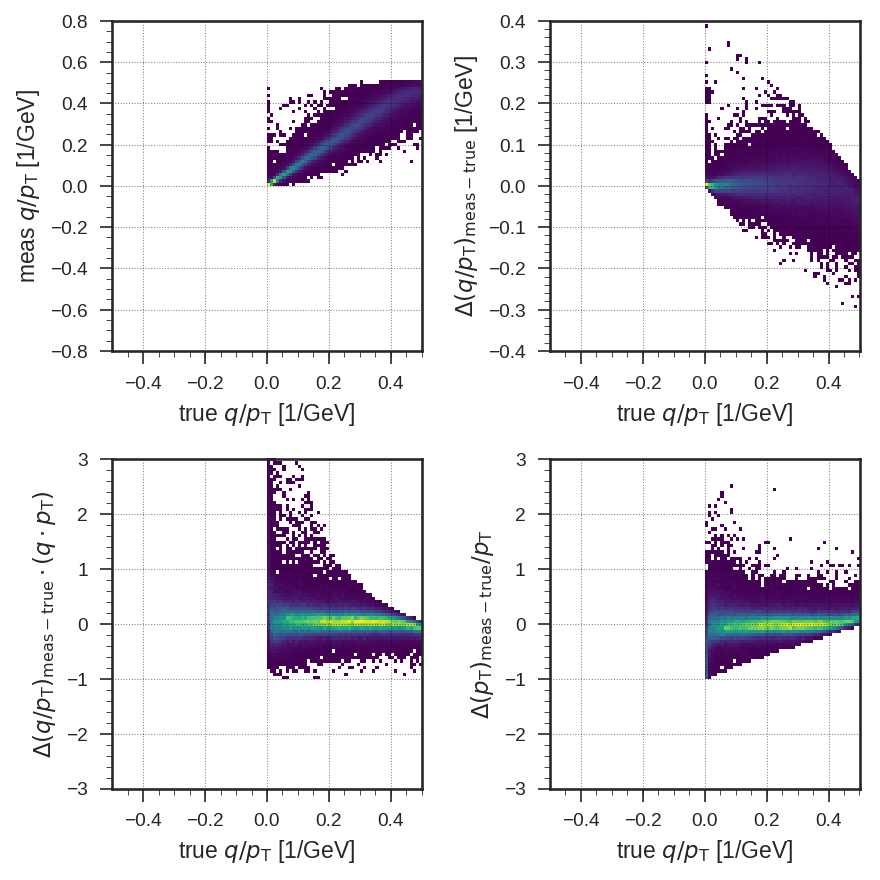

In [21]:
# Plot regression
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = y_test_true
yy = y_test_pred_regr
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0,0].set_ylabel(r'meas $q/p_{\mathrm{T}}$ [1/GeV]')

yy = y_test_pred_regr - y_test_true
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0,1].set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')

yy = (y_test_pred_regr - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1,0].set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}} \cdot (q \cdot p_{\mathrm{T}})$')

yy = np.abs(y_test_true/y_test_pred_regr) - 1
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1,1].set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$')

plt.show()

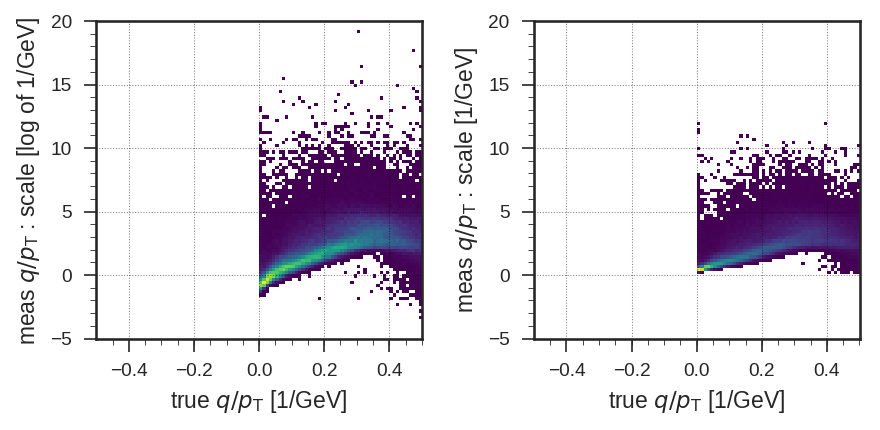

In [22]:
# Plot 'scale'
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

xx = y_test_true
yy = 0.01 * y_test_pred_scale_logit
axs[0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-5,20)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0].set_ylabel(r'meas $q/p_{\mathrm{T}}$ : scale [log of 1/GeV]')

xx = y_test_true
yy = y_test_pred_scale
axs[1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-5,20)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1].set_ylabel(r'meas $q/p_{\mathrm{T}}$ : scale [1/GeV]')

plt.show()

In [23]:
# Make better resolution plot
# resolution defined as delta pT over pT (no charge), binned in 1/pT (also no charge)
xx = np.abs(y_test_true)
yy = np.abs(y_test_true/y_test_pred_regr) - 1
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
uuu = np.zeros(nbinsx, dtype=np.float32)

for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print i, len(xx_i), zdata.sum(), hightail
  
  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]
  
  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage
  uuu[i] = popt[1]

[INFO    ] gaus fit (a, mu, sig): 8.417390e+01, -5.522088e-02, 1.461418e-01
[INFO    ] gaus fit (a, mu, sig): 6.908254e+01, -5.283542e-02, 1.859997e-01


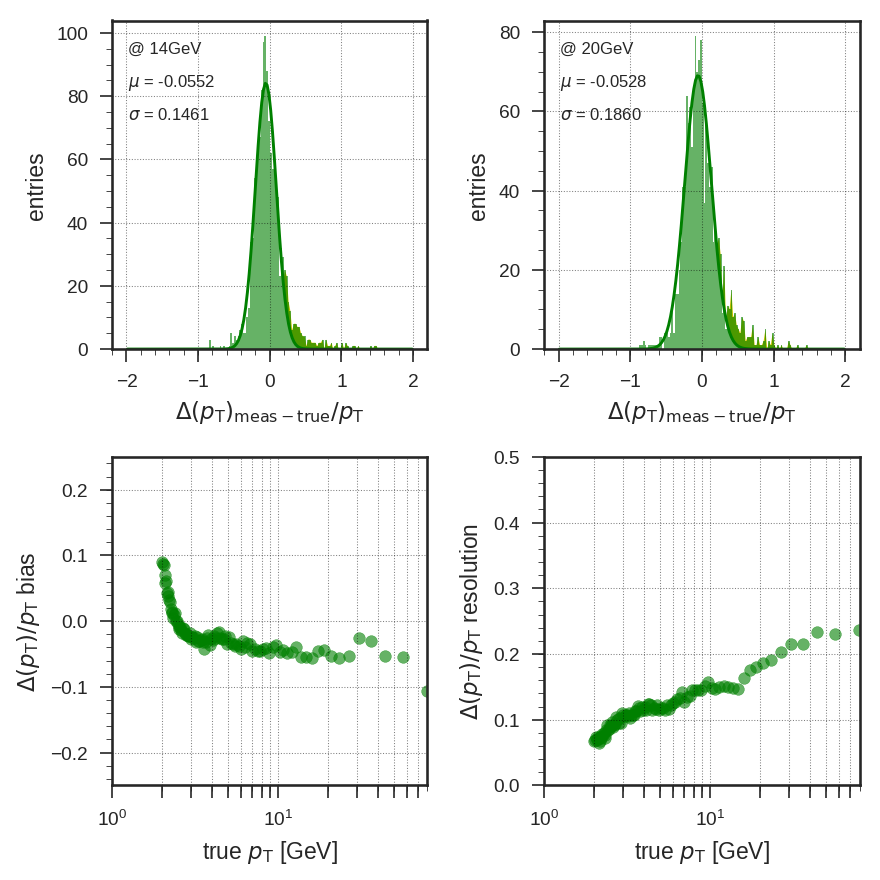

In [24]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = (hist - ydata)
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
#yy = yy_25GeV
#pt = 25
#doit()
ax.scatter(xxx, uuu, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(-0.25,0.25)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ bias')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

[INFO    ] high tail prob: 8.637545e-02, 9.735636e-02, 1.025739e-01


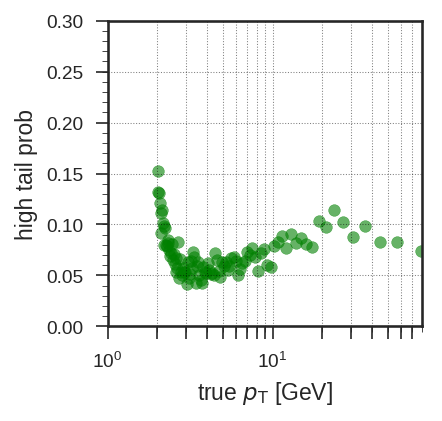

In [25]:
# Estimate high tail that is underestimated by gaus fit
logger.info('high tail prob: {0:e}, {1:e}, {2:e}'.format(zzz[ind_14GeV],zzz[ind_20GeV],zzz[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, zzz, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.3)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'high tail prob')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

[INFO    ] coverage # of sigmas: 1.568591e+00, 1.420953e+00, 1.366122e+00


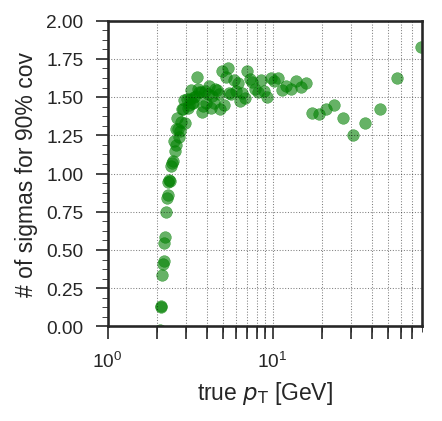

In [26]:
# Estimate coverage, find required number of sigmas for 90% coverage
# If truly gaussian, the required number of sigmas is 1.28155
#print scipy.special.erfinv(0.80) * np.sqrt(2)
logger.info('coverage # of sigmas: {0:e}, {1:e}, {2:e}'.format(ttt[ind_14GeV],ttt[ind_20GeV],ttt[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, ttt, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,2)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'# of sigmas for 90% cov')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

### Validating Loss Function

In [27]:
if do_training:
  y_train_pred = loaded_model.predict(val_x_train_new, batch_size=4096)
  y_train_true = val_y_train_new
  if y_train_true.ndim == 1:
    y_train_true = y_train_true[:, np.newaxis]

  loss, components = model.emlf.loss_fn_with_components(y_train_true, y_train_pred)
  #print loss, components

  sess = K.get_session()
  loss_e, components_e = sess.run([loss, components])
  #print loss_e, components_e

In [28]:
if do_training:
  (y_true0, log_prob0, masks_lp0, log_prob_q0, masks_lpq0, log_prob_pu0, masks_lppu0,
   y_true1, log_prob1, masks_lp1, log_prob_q1, masks_lpq1, log_prob_pu1, masks_lppu1,
   y_true2, log_prob2, masks_lp2, log_prob_q2, masks_lpq2, log_prob_pu2, masks_lppu2) = components_e

  loss = loss_e.mean()
  loss0 = -(log_prob0 * masks_lp0 + log_prob_pu0 * masks_lppu0).mean()
  loss1 = -(log_prob1 * masks_lp1 + log_prob_pu1 * masks_lppu1).mean()
  loss2 = -(log_prob2 * masks_lp2 + log_prob_pu2 * masks_lppu2).mean()

  loss_lp0 = -(log_prob0 * masks_lp0).mean()
  loss_lpq0 = -(log_prob_q0 * masks_lpq0).mean()
  loss_lppu0 = -(log_prob_pu0 * masks_lppu0).mean()
  loss_lp1 = -(log_prob1 * masks_lp1).mean()
  loss_lpq1 = -(log_prob_q1 * masks_lpq1).mean()
  loss_lppu1 = -(log_prob_pu1 * masks_lppu1).mean()
  loss_lp2 = -(log_prob2 * masks_lp2).mean()
  loss_lpq2 = -(log_prob_q2 * masks_lpq2).mean()
  loss_lppu2 = -(log_prob_pu2 * masks_lppu2).mean()

  print('loss: {0} loss0: {1} loss1: {2} loss2: {3}'.format(loss, loss0, loss1, loss2,))
  print('loss_lp0: {0} loss_lpq0: {1} loss_lppu0: {2}'.format(loss_lp0, loss_lpq0, loss_lppu0))
  print('loss_lp1: {0} loss_lpq1: {1} loss_lppu1: {2}'.format(loss_lp1, loss_lpq1, loss_lppu1))
  print('loss_lp2: {0} loss_lpq2: {1} loss_lppu2: {2}'.format(loss_lp2, loss_lpq2, loss_lppu2))

  print -log_prob0[masks_lp0 > 0].min(), -log_prob0[masks_lp0 > 0].max(), -log_prob_pu0[masks_lppu0 > 0].min(), -log_prob_pu0[masks_lppu0 > 0].max()
  print y_true0[(masks_lp0 > 0) & (-log_prob0 > 500)], y_true0[(masks_lppu0 > 0) & (-log_prob0 > 500)]
  print -log_prob1[masks_lp1 > 0].min(), -log_prob1[masks_lp1 > 0].max(), -log_prob_pu1[masks_lppu1 > 0].min(), -log_prob_pu1[masks_lppu1 > 0].max()
  print y_true1[(masks_lp1 > 0) & (-log_prob1 > 500)], y_true1[(masks_lppu1 > 0) & (-log_prob1 > 500)]
  print -log_prob2[masks_lp2 > 0].min(), -log_prob2[masks_lp2 > 0].max(), -log_prob_pu2[masks_lppu2 > 0].min(), -log_prob_pu2[masks_lppu2 > 0].max()
  print y_true2[(masks_lp2 > 0) & (-log_prob2 > 500)], y_true2[(masks_lppu2 > 0) & (-log_prob2 > 500)]

  history['val_loss0'] = loss0
  history['val_loss1'] = loss1
  history['val_loss2'] = loss2
  save_my_history(history, name=model_name)

In [29]:
# Plot loss

if do_training:
  fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)
  axs[0].hist2d(y_true0[masks_lp0 > 0], -log_prob0[masks_lp0 > 0], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
  axs[0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV] {muon}')
  axs[0].set_ylabel('loss')
  axs[1].hist2d(y_true0[masks_lppu0 > 0], -log_prob0[masks_lppu0 > 0], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
  axs[1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV] {pileup}')
  axs[1].set_ylabel('loss')
  plt.show()

In [30]:
if do_training:
  #x = np.abs(y_train_true[..., 0:1])
  x = y_true0
  loc = get_loc(y_train_pred[..., 0:1])
  scale = get_scale(y_train_pred[..., 2:3])
  standardize = lambda x: (x - loc) / scale
  standardize_noscale = lambda x: (x - loc)

  masks_pileup = (y_train_true[..., 3:4] == MASKS.pileup)
  masks_pileupx = (y_train_true[..., 3:4] == MASKS.pileupx)

  fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)
  axs[0].hist2d(standardize(x)[masks_pileup], -log_prob0[masks_pileup], bins=(100,100), range=((-100,100),(0,100)), vmin=1, cmap=my_cmap)
  axs[0].set_xlabel(r'$z$ {pileup}')
  axs[0].set_ylabel('loss')
  axs[1].hist2d(standardize(x)[masks_pileupx], -log_prob0[masks_pileupx], bins=(100,100), range=((-100,100),(0,100)), vmin=1, cmap=my_cmap)
  axs[1].set_xlabel(r'$z$ {pileupx}')
  axs[1].set_ylabel('loss')
  plt.show()

  fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)
  axs[0].hist2d(standardize(x)[masks_pileup], np.log(scale)[masks_pileup], bins=(100,100), range=((-50,50),(-10,10)), vmin=1, cmap=my_cmap)
  axs[0].set_xlabel(r'$z$ {pileup}')
  axs[0].set_ylabel('loss')
  axs[1].hist2d(standardize(x)[masks_pileupx], np.log(scale)[masks_pileupx], bins=(100,100), range=((-50,50),(-10,10)), vmin=1, cmap=my_cmap)
  axs[1].set_xlabel(r'$z$ {pileupx}')
  axs[1].set_ylabel('loss')
  #plt.show()

  fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)
  axs[0].hist2d(standardize(x)[masks_pileup], (scale)[masks_pileup], bins=(100,100), range=((-50,50),(-5,20)), vmin=1, cmap=my_cmap)
  axs[0].set_xlabel(r'$z$ {pileup}')
  axs[0].set_ylabel('loss')
  axs[1].hist2d(standardize(x)[masks_pileupx], (scale)[masks_pileupx], bins=(100,100), range=((-50,50),(-5,20)), vmin=1, cmap=my_cmap)
  axs[1].set_xlabel(r'$z$ {pileupx}')
  axs[1].set_ylabel('loss')
  plt.show()

In [31]:
if do_training:
  fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)
  axs[0].hist2d(standardize_noscale(x)[masks_pileup], -log_prob0[masks_pileup], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
  axs[0].set_xlabel(r'$z$ {pileup}')
  axs[0].set_ylabel('loss')
  axs[1].hist2d(standardize_noscale(x)[masks_pileupx], -log_prob0[masks_pileupx], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
  axs[1].set_xlabel(r'$z$ {pileupx}')
  axs[1].set_ylabel('loss')
  plt.show()

In [32]:
if do_training:  
  fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)
  axs[0].hist2d((loc)[masks_pileup], -log_prob0[masks_pileup], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
  axs[0].set_xlabel(r'meas $q/p_{\mathrm{T}}$ [1/GeV] {pileup}')
  axs[0].set_ylabel('loss')
  axs[1].hist2d((loc)[masks_pileupx], -log_prob0[masks_pileupx], bins=(100,100), range=((-50,50),(0,100)), vmin=1, cmap=my_cmap)
  axs[1].set_xlabel(r'meas $q/p_{\mathrm{T}}$ [1/GeV] {pileupx}')
  axs[1].set_ylabel('loss')
  #plt.show()

  fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)
  axs[0].hist2d((loc)[masks_pileup], np.log(scale)[masks_pileup], bins=(100,100), range=((-50,50),(-10,10)), vmin=1, cmap=my_cmap)
  axs[0].set_xlabel(r'meas $q/p_{\mathrm{T}}$ [1/GeV] {pileup}')
  axs[0].set_ylabel('loss')
  axs[1].hist2d((loc)[masks_pileupx], np.log(scale)[masks_pileupx], bins=(100,100), range=((-50,50),(-10,10)), vmin=1, cmap=my_cmap)
  axs[1].set_xlabel(r'meas $q/p_{\mathrm{T}}$ [1/GeV] {pileupx}')
  axs[1].set_ylabel('loss')
  #plt.show()

  fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)
  axs[0].hist2d((loc)[masks_pileup], (scale)[masks_pileup], bins=(100,100), range=((-50,50),(-5,20)), vmin=1, cmap=my_cmap)
  axs[0].set_xlabel(r'meas $q/p_{\mathrm{T}}$ [1/GeV] {pileup}')
  axs[0].set_ylabel('loss')
  axs[1].hist2d((loc)[masks_pileupx], (scale)[masks_pileupx], bins=(100,100), range=((-50,50),(-5,20)), vmin=1, cmap=my_cmap)
  axs[1].set_xlabel(r'meas $q/p_{\mathrm{T}}$ [1/GeV] {pileupx}')
  axs[1].set_ylabel('loss')
  plt.show()

### Regression Results &ndash; displaced muons pT

In [33]:
# Prepare d1_test_true, d1_test_pred,
#         d0_test_true, d0_test_pred
d1_test_true = get_true_y(np.hstack((displ1_y_test[:nentries_test/2], displ2_y_test[:nentries_test/2])))
d0_test_true = get_true_dxy(np.hstack((displ1_dxy_test[:nentries_test/2], displ2_dxy_test[:nentries_test/2])))

d1_test_pred = np.vstack((loaded_model.predict(displ1_x_test[:nentries_test/2], batch_size=4096),
                          loaded_model.predict(displ2_x_test[:nentries_test/2], batch_size=4096),))
d1_test_pred, d0_test_pred = d1_test_pred[..., 3:6], d1_test_pred[..., 6:9]

d1_test_pred_loc, d1_test_pred_sign, d1_test_pred_scale = get_loc(d1_test_pred[..., 0:1]), get_sign(d1_test_pred[..., 1:2]), get_scale(d1_test_pred[..., 2:3])
d1_test_pred_scale_logit = d1_test_pred[..., 2:3]
d1_test_pred_regr = get_regr_y(d1_test_pred_loc)
d1_test_pred_discr = get_discr(d1_test_pred_loc, d1_test_pred_scale)

d0_test_pred_loc, d0_test_pred_sign, d0_test_pred_scale = get_loc_dxy(d0_test_pred[..., 0:1]), get_sign(d0_test_pred[..., 1:2]), get_scale(d0_test_pred[..., 2:3])
d0_test_pred_scale_logit = d0_test_pred[..., 2:3]
d0_test_pred_regr = get_regr_dxy(d0_test_pred_loc)
d0_test_pred_discr = get_discr(d0_test_pred_loc, d0_test_pred_scale)

#print d1_test_true.shape, d1_test_true
#print d1_test_pred.shape, d1_test_pred
#print d0_test_true.shape, d0_test_true
#print d0_test_pred.shape, d0_test_pred

In [34]:
# Prepare pu_d1_test_true, pu_d1_test_pred,
#         pu_d0_test_true, pu_d0_test_pred
pu_d1_test_true = get_true_y(pu_y_test)
pu_d0_test_true = get_true_dxy(pu_dxy_test)

pu_d1_test_pred = loaded_model.predict(pu_x_test, batch_size=4096)
pu_d1_test_pred, pu_d0_test_pred = pu_d1_test_pred[..., 3:6], pu_d1_test_pred[..., 6:9]

pu_d1_test_pred_loc, pu_d1_test_pred_sign, pu_d1_test_pred_scale = get_loc(pu_d1_test_pred[..., 0:1]), get_sign(pu_d1_test_pred[..., 1:2]), get_scale(pu_d1_test_pred[..., 2:3])
pu_d1_test_pred_regr = get_regr_y(pu_d1_test_pred_loc)
pu_d1_test_pred_discr = get_discr(pu_d1_test_pred_loc, pu_d1_test_pred_scale)

pu_d0_test_pred_loc, pu_d0_test_pred_sign, pu_d0_test_pred_scale = get_loc_dxy(pu_d0_test_pred[..., 0:1]), get_sign(pu_d0_test_pred[..., 1:2]), get_scale(pu_d0_test_pred[..., 2:3])
pu_d0_test_pred_regr = get_regr_dxy(pu_d0_test_pred_loc)
pu_d0_test_pred_discr = get_discr(pu_d0_test_pred_loc, pu_d0_test_pred_scale)

#print pu_d1_test_true.shape, pu_d1_test_true
#print pu_d1_test_pred.shape, pu_d1_test_pred
#print pu_d0_test_true.shape, pu_d0_test_true
#print pu_d0_test_pred.shape, pu_d0_test_pred

[INFO    ] # of entries: 124468, mean: 2.235487e-03, std: 8.012314e-02, mse: 6.424716e-03, mae: 5.642405e-02, mad: 5.688917e-02
[INFO    ] gaus fit (a, mu, sig): 8.646391e+03, 3.867485e-03, 5.117389e-02
[INFO    ] # of entries: 23090, mean: 6.174972e-02, std: 5.206817e-02, mse: 9.357142e-03, mae: 6.522471e-02, mad: 5.660530e-02
[INFO    ] gaus fit (a, mu, sig): 7.406027e+02, 2.591287e-02, 3.325449e-02


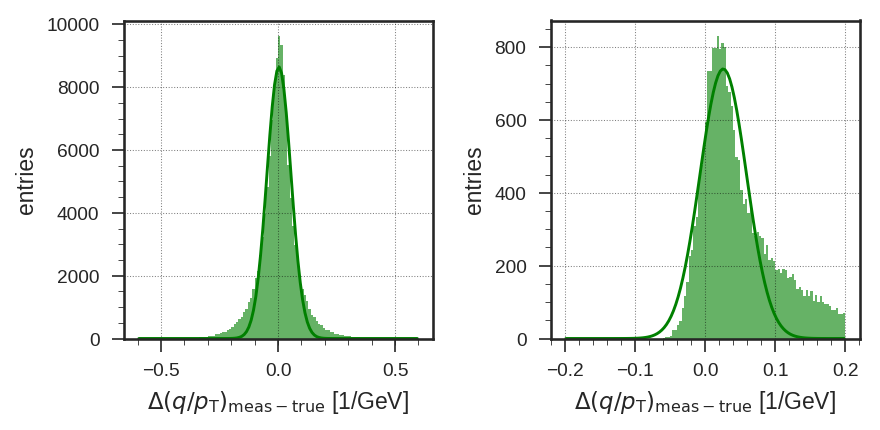

In [35]:
# Plot Delta(q/pT)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = d1_test_true
yb = d1_test_pred_regr
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=120, range=(-0.6,0.6), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.6]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.6]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')
axs[0].set_ylabel(r'entries')

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/d1_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=120, range=(-0.6/3,0.6/3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.6/3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.6/3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')
axs[1].set_ylabel(r'entries')

plt.show()

[INFO    ] # of entries: 124468, mean: 4.429747e-03, std: 4.197666e-01, mse: 2.518235e-01, mae: 3.338682e-01, mad: 3.234164e-01
[INFO    ] gaus fit (a, mu, sig): 5.699558e+03, -1.650854e-02, 2.818547e-01
[INFO    ] # of entries: 23090, mean: -4.587815e-01, std: 4.249687e-01, mse: 4.448293e-01, mae: 5.772498e-01, mad: 8.893045e-01
[INFO    ] gaus fit (a, mu, sig): 9.681362e+02, -6.240546e-01, 3.361238e-01


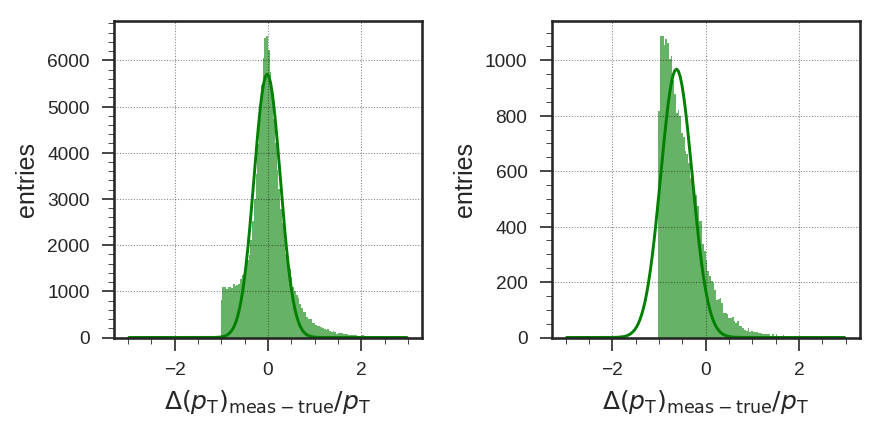

In [36]:
# Plot Delta(q/pT) / pT
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(d1_test_true/d1_test_true)
yb = np.abs(d1_test_true/d1_test_pred_regr)
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=160, range=(-3,3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<1.5]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$', fontsize=12)
axs[0].set_ylabel(r'entries', fontsize=12)

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/d1_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=160, range=(-3,3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<1.5]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$', fontsize=12)
axs[1].set_ylabel(r'entries', fontsize=12)

plt.show()

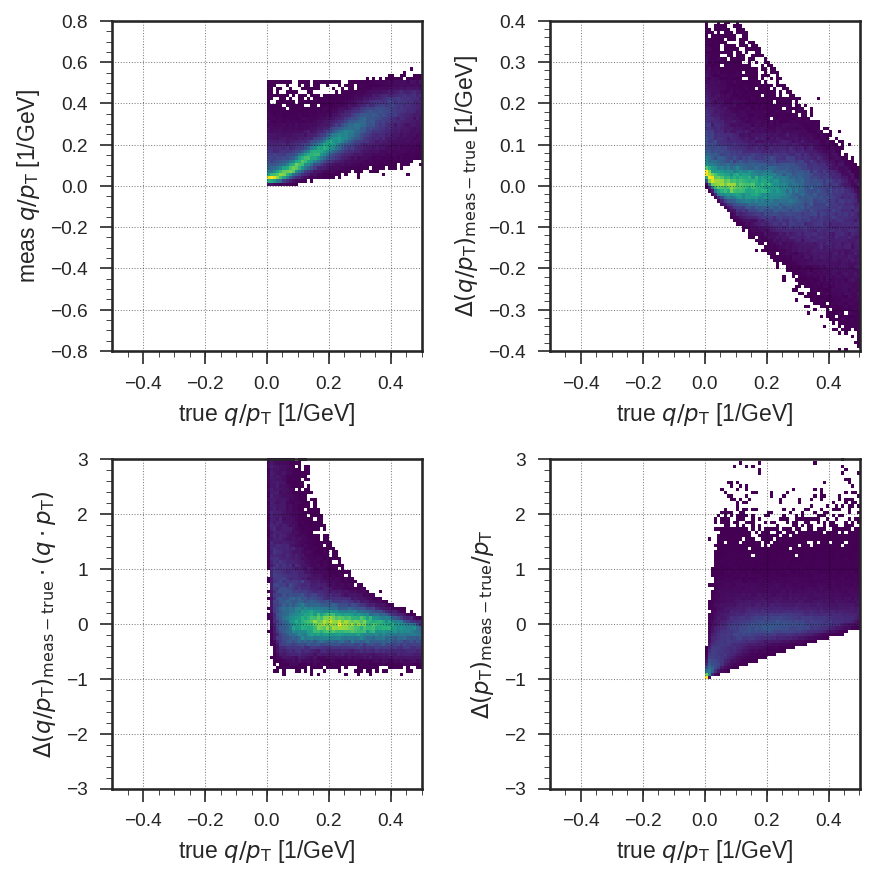

In [37]:
# Plot regression
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = d1_test_true
yy = d1_test_pred_regr
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0,0].set_ylabel(r'meas $q/p_{\mathrm{T}}$ [1/GeV]')

yy = d1_test_pred_regr - d1_test_true
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0,1].set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')

yy = (d1_test_pred_regr - d1_test_true)/np.abs(d1_test_true)
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1,0].set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}} \cdot (q \cdot p_{\mathrm{T}})$')

yy = np.abs(d1_test_true/d1_test_pred_regr) - 1
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1,1].set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$')

plt.show()

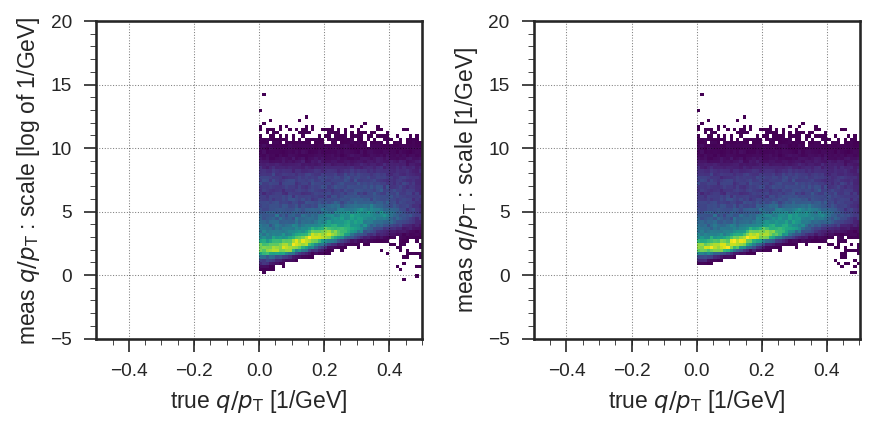

In [38]:
# Plot 'scale'
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

xx = d1_test_true
yy = 0.01 * d1_test_pred_scale_logit
axs[0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-5,20)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0].set_ylabel(r'meas $q/p_{\mathrm{T}}$ : scale [log of 1/GeV]')

xx = d1_test_true
yy = d1_test_pred_scale
axs[1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-5,20)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1].set_ylabel(r'meas $q/p_{\mathrm{T}}$ : scale [1/GeV]')

plt.show()

In [39]:
# Make better resolution plot
# resolution defined as delta pT over pT (no charge), binned in 1/pT (also no charge)
xx = np.abs(d1_test_true)
#yy = np.abs(d1_test_true/d1_test_pred_regr) - 1
yy = -(d1_test_pred_regr - d1_test_true)/np.abs(d1_test_true)
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
uuu = np.zeros(nbinsx, dtype=np.float32)

for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-3 <= yy_i) & (yy_i <= 3)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  #assert(np.abs(mu) < 1)
  #assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-3,3))
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print i, len(xx_i), zdata.sum(), hightail
  
  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]
  
  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage
  uuu[i] = popt[1]

[INFO    ] gaus fit (a, mu, sig): 3.839883e+01, -1.518914e-01, 5.207450e-01
[INFO    ] gaus fit (a, mu, sig): 3.071702e+01, -3.735110e-01, 6.746609e-01


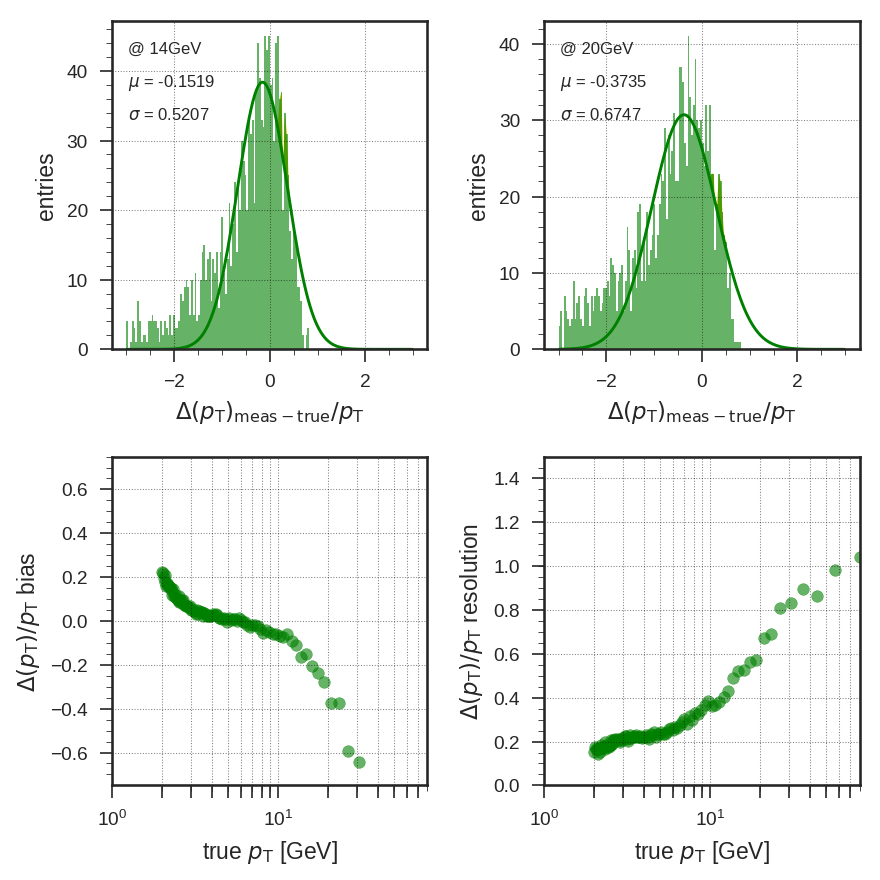

In [40]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-3,3), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = (hist - ydata)
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
#yy = yy_25GeV
#pt = 25
#doit()
ax.scatter(xxx, uuu, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(-0.25*3,0.25*3)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ bias')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5*3)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

In [41]:
# Quick efficiency
sel = np.abs(1.0/d1_test_true) > 60.
denom = sel.sum()
print 'Targeting true pT > 60 GeV'
for l in [0, 5, 10, 15, 20, 30, 40, 50, 60]:
  sel_l = np.abs(1.0/d1_test_pred_regr) > l
  numer = (sel & sel_l).sum()
  print 'L1 pT > %2i GeV eff: %.2f' % (l, np.true_divide(numer, denom) * 100)

Targeting true pT > 60 GeV
L1 pT >  0 GeV eff: 100.00
L1 pT >  5 GeV eff: 88.96
L1 pT > 10 GeV eff: 65.06
L1 pT > 15 GeV eff: 49.88
L1 pT > 20 GeV eff: 37.15
L1 pT > 30 GeV eff: 16.26
L1 pT > 40 GeV eff: 5.93
L1 pT > 50 GeV eff: 2.72
L1 pT > 60 GeV eff: 1.23


### Regression Results &ndash; displaced muons d0

[INFO    ] # of entries: 124468, mean: -3.371235e+00, std: 1.436938e+01, mse: 2.517628e+02, mae: 1.104272e+01, mad: 1.113441e+01
[INFO    ] gaus fit (a, mu, sig): 4.377492e+03, -1.512643e+00, 1.033243e+01
[INFO    ] # of entries: 23090, mean: -2.787501e+00, std: 7.164075e+00, mse: 1.252108e+02, mae: 7.197288e+00, mad: 7.004590e+00
[INFO    ] gaus fit (a, mu, sig): 6.526023e+02, -1.052396e+00, 6.411441e+00


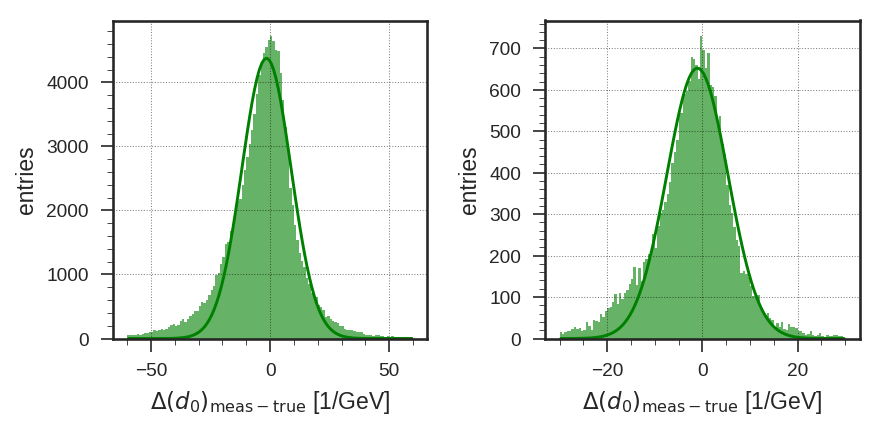

In [42]:
# Plot Delta(d0)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = d0_test_true
yb = d0_test_pred_regr
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=120, range=(-60,60), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<60]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<60]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [1/GeV]')
axs[0].set_ylabel(r'entries')

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/d1_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=120, range=(-60/2,60/2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<60/3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<60/3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [1/GeV]')
axs[1].set_ylabel(r'entries')

plt.show()

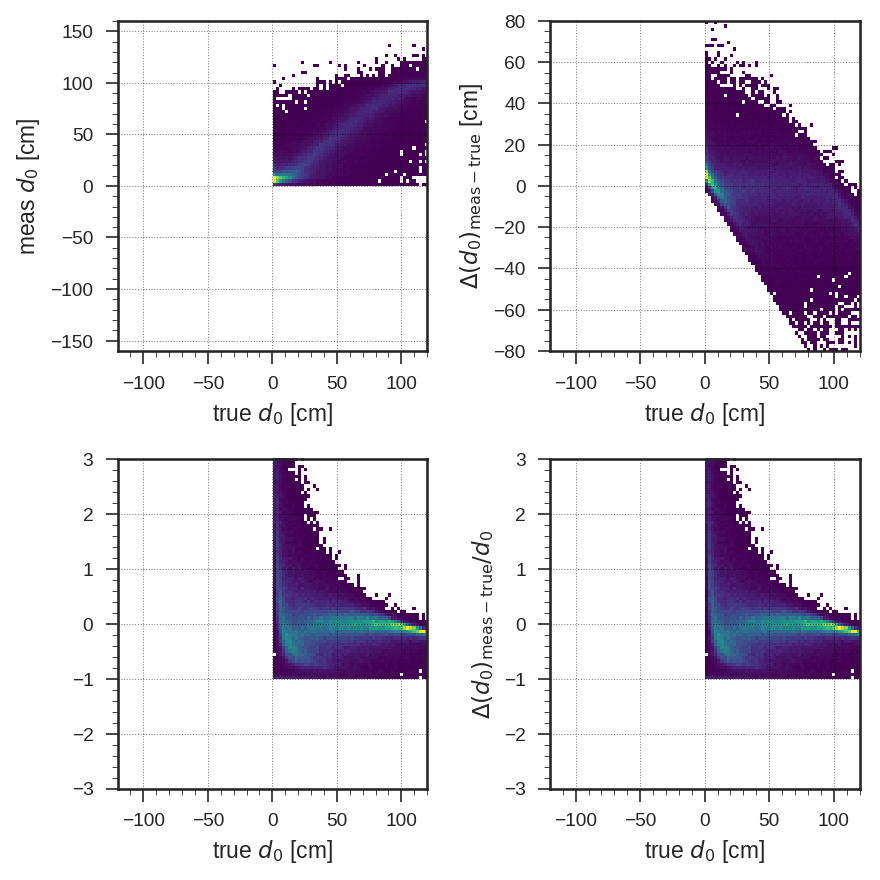

In [43]:
# Plot regression
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = d0_test_true
yy = d0_test_pred_regr
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-160,160)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $d_{0}$ [cm]')
axs[0,0].set_ylabel(r'meas $d_{0}$ [cm]')

yy = d0_test_pred_regr - d0_test_true
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-80,80)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $d_{0}$ [cm]')
axs[0,1].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')

yy = (d0_test_pred_regr - d0_test_true)/np.abs(d0_test_true)
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $d_{0}$ [cm]')
axs[1,1].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}} / d_{0}$')

yy = np.abs(d0_test_pred_regr/d0_test_true) - 1
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $d_{0}$ [cm]')
axs[1,1].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}} / d_{0}$')

plt.show()

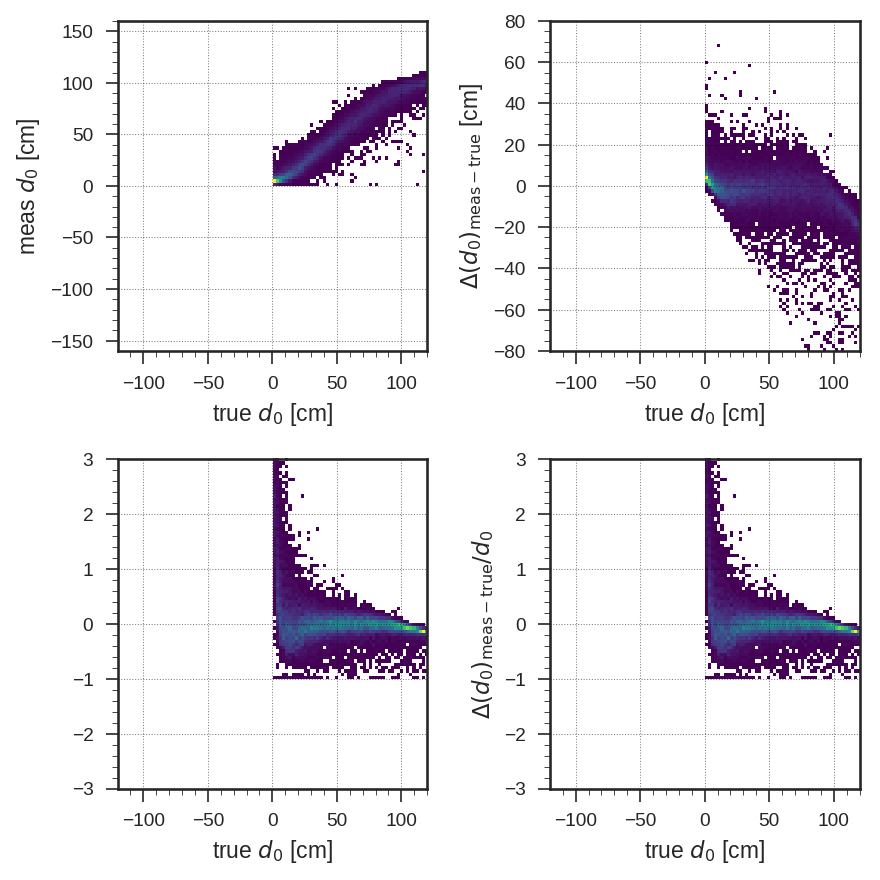

In [44]:
# Plot regression
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = d0_test_true[sel]
yy = d0_test_pred_regr[sel]
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-160,160)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $d_{0}$ [cm]')
axs[0,0].set_ylabel(r'meas $d_{0}$ [cm]')

yy = (d0_test_pred_regr - d0_test_true)[sel]
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-80,80)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $d_{0}$ [cm]')
axs[0,1].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')

yy = ((d0_test_pred_regr - d0_test_true)/np.abs(d0_test_true))[sel]
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $d_{0}$ [cm]')
axs[1,1].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}} / d_{0}$')

yy = (np.abs(d0_test_pred_regr/d0_test_true) - 1)[sel]
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $d_{0}$ [cm]')
axs[1,1].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}} / d_{0}$')

plt.show()

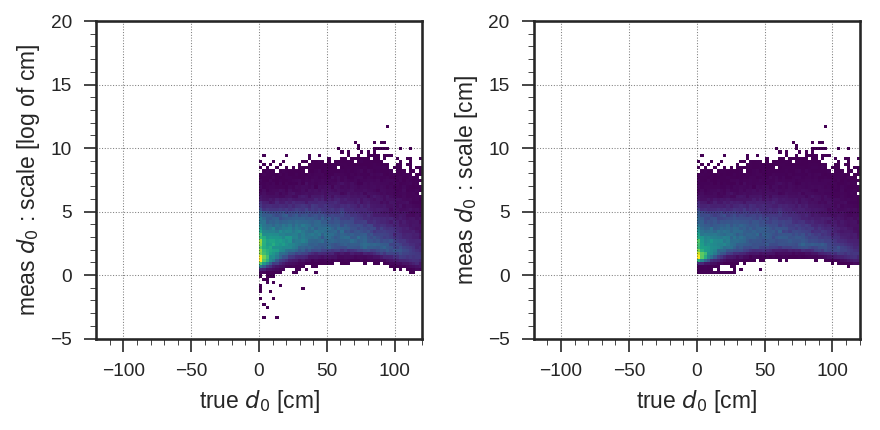

In [45]:
# Plot 'scale'
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

xx = d0_test_true
yy = 0.01 * d0_test_pred_scale_logit
axs[0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-5,20)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'true $d_{0}$ [cm]')
axs[0].set_ylabel(r'meas $d_{0}$ : scale [log of cm]')

xx = d0_test_true
yy = d0_test_pred_scale
axs[1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-5,20)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'true $d_{0}$ [cm]')
axs[1].set_ylabel(r'meas $d_{0}$ : scale [cm]')

plt.show()

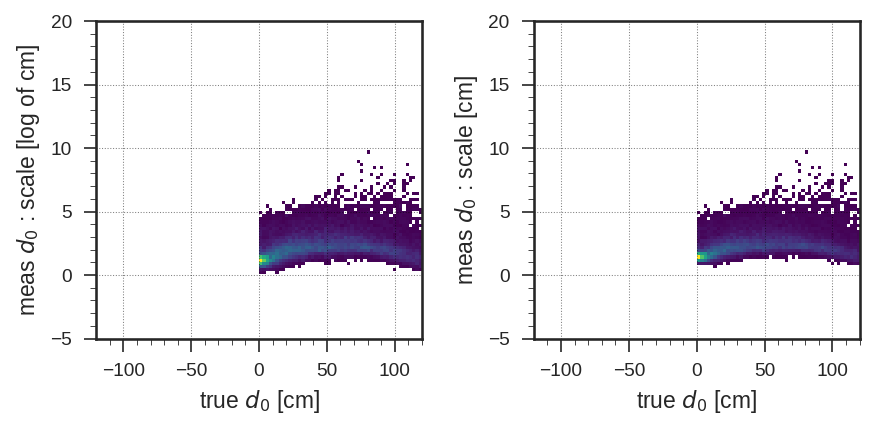

In [46]:
# Plot 'scale'
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

xx = d0_test_true[sel]
yy = 0.01 * d0_test_pred_scale_logit[sel]
axs[0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-5,20)), vmin=1, cmap=my_cmap)
axs[0].set_xlabel(r'true $d_{0}$ [cm]')
axs[0].set_ylabel(r'meas $d_{0}$ : scale [log of cm]')

xx = d0_test_true[sel]
yy = d0_test_pred_scale[sel]
axs[1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-5,20)), vmin=1, cmap=my_cmap)
axs[1].set_xlabel(r'true $d_{0}$ [cm]')
axs[1].set_ylabel(r'meas $d_{0}$ : scale [cm]')

plt.show()

In [47]:
# Make better resolution plot
# resolution defined as delta pT over pT (no charge), binned in 1/pT (also no charge)
xx = np.abs(d1_test_true)
yy = (d0_test_pred_regr - d0_test_true)
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
uuu = np.zeros(nbinsx, dtype=np.float32)

for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-60/2 <= yy_i) & (yy_i <= 60/2)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  #assert(np.abs(mu) < 1)
  #assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-60/2,60/2))
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=6)
  #print i, len(xx_i), mu, sig, pt, popt
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print i, len(xx_i), zdata.sum(), hightail
  
  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]
  
  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage
  uuu[i] = popt[1]

[INFO    ] gaus fit (a, mu, sig): 3.056597e+01, -1.133559e+00, 7.146684e+00
[INFO    ] gaus fit (a, mu, sig): 3.584176e+01, -1.007622e+00, 6.569384e+00


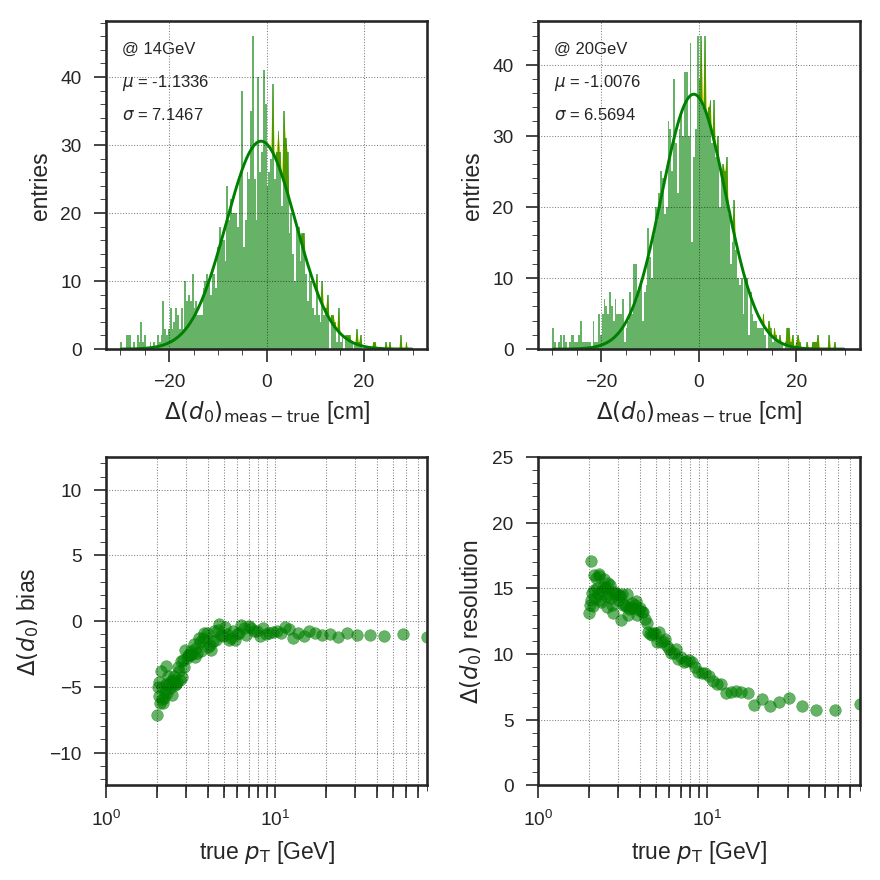

In [48]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-60/2,60/2), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=6)
  logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = (hist - ydata)
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')
  ax.set_ylabel(r'entries')

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
#yy = yy_25GeV
#pt = 25
#doit()
ax.scatter(xxx, uuu, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(-12.5,12.5)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(d_{0})$ bias')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,25)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(d_{0})$ resolution')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

In [49]:
# Quick efficiency
sel = (np.abs(1.0/d1_test_true) > 60.) & (np.abs(d0_test_true) > 75.)
denom = sel.sum()
print 'Targeting true pT > 60 GeV & |d0| > 75 cm'
for l in [0, 5]:
  for m in [0, 5, 10, 20, 30, 40, 50, 60, 75]:
    sel_l = np.abs(1.0/d1_test_pred_regr) > l
    sel_m = np.abs(d0_test_pred_regr) > m
    numer = (sel & sel_l & sel_m).sum()
    print 'L1 pT > %2i GeV & |d0| > %2i cm eff: %.2f' % (l, m, np.true_divide(numer, denom) * 100)

Targeting true pT > 60 GeV & |d0| > 75 cm
L1 pT >  0 GeV & |d0| >  0 cm eff: 99.79
L1 pT >  0 GeV & |d0| >  5 cm eff: 99.37
L1 pT >  0 GeV & |d0| > 10 cm eff: 99.37
L1 pT >  0 GeV & |d0| > 20 cm eff: 98.95
L1 pT >  0 GeV & |d0| > 30 cm eff: 98.46
L1 pT >  0 GeV & |d0| > 40 cm eff: 97.06
L1 pT >  0 GeV & |d0| > 50 cm eff: 95.30
L1 pT >  0 GeV & |d0| > 60 cm eff: 92.71
L1 pT >  0 GeV & |d0| > 75 cm eff: 81.29
L1 pT >  5 GeV & |d0| >  0 cm eff: 89.21
L1 pT >  5 GeV & |d0| >  5 cm eff: 89.21
L1 pT >  5 GeV & |d0| > 10 cm eff: 89.21
L1 pT >  5 GeV & |d0| > 20 cm eff: 89.14
L1 pT >  5 GeV & |d0| > 30 cm eff: 89.14
L1 pT >  5 GeV & |d0| > 40 cm eff: 89.07
L1 pT >  5 GeV & |d0| > 50 cm eff: 88.37
L1 pT >  5 GeV & |d0| > 60 cm eff: 87.11
L1 pT >  5 GeV & |d0| > 75 cm eff: 77.51


In [50]:
# Quick efficiency
sel = (np.abs(1.0/d1_test_true) > 60.) & (np.abs(d0_test_true) > 20.)
denom = sel.sum()
print 'Targeting true pT > 60 GeV & |d0| > 20 cm'
for l in [0, 5]:
  for m in [0, 5, 10, 15, 20, 25, 30, 35, 40]:
    sel_l = np.abs(1.0/d1_test_pred_regr) > l
    sel_m = np.abs(d0_test_pred_regr) > m
    numer = (sel & sel_l & sel_m).sum()
    print 'L1 pT > %2i GeV & |d0| > %2i cm eff: %.2f' % (l, m, np.true_divide(numer, denom) * 100)

Targeting true pT > 60 GeV & |d0| > 20 cm
L1 pT >  0 GeV & |d0| >  0 cm eff: 99.92
L1 pT >  0 GeV & |d0| >  5 cm eff: 99.47
L1 pT >  0 GeV & |d0| > 10 cm eff: 98.51
L1 pT >  0 GeV & |d0| > 15 cm eff: 96.91
L1 pT >  0 GeV & |d0| > 20 cm eff: 93.40
L1 pT >  0 GeV & |d0| > 25 cm eff: 87.58
L1 pT >  0 GeV & |d0| > 30 cm eff: 80.93
L1 pT >  0 GeV & |d0| > 35 cm eff: 75.19
L1 pT >  0 GeV & |d0| > 40 cm eff: 69.35
L1 pT >  5 GeV & |d0| >  0 cm eff: 87.89
L1 pT >  5 GeV & |d0| >  5 cm eff: 87.86
L1 pT >  5 GeV & |d0| > 10 cm eff: 87.48
L1 pT >  5 GeV & |d0| > 15 cm eff: 86.52
L1 pT >  5 GeV & |d0| > 20 cm eff: 83.79
L1 pT >  5 GeV & |d0| > 25 cm eff: 78.73
L1 pT >  5 GeV & |d0| > 30 cm eff: 73.14
L1 pT >  5 GeV & |d0| > 35 cm eff: 68.34
L1 pT >  5 GeV & |d0| > 40 cm eff: 63.23


### Efficiency & Rates

In [51]:
# Build track producer

from six.moves import range, zip, map, filter

#pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

pt_bins = (-0.49376795, -0.38895044, -0.288812, -0.19121648, -0.0810074, 0.0810074, 0.19121648, 0.288812, 0.38895044, 0.49376795)

#pt_bins = (-0.49349323, -0.38373062, -0.28128058, -0.18467896, -0.07760702, 0.07760702, 0.18467896, 0.28128058, 0.38373062, 0.49349323)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  lut = np.array([1,3,5,7,9,7,5,3,1,0,2,4,6,8,6,4,2,0], dtype=np.int32)
  return lut[ipt]

theta_to_eta_lut = [
  2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
  2.309, 2.284, 2.259, 2.236, 2.212, 2.190, 2.167, 2.145, 2.124, 2.103,
  2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.950, 1.932, 1.915,
  1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.800, 1.785, 1.770, 1.755,
  1.740, 1.726, 1.711, 1.697, 1.683, 1.670, 1.656, 1.642, 1.629, 1.616,
  1.603, 1.590, 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
  1.482, 1.470, 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
  1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
  1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
  1.180, 1.171, 1.162, 1.154, 1.145, 1.136, 1.128, 1.119, 1.111, 1.103,
  1.094, 1.086, 1.078, 1.070, 1.062, 1.054, 1.046, 1.038, 1.030, 1.022,
  1.014, 1.007, 0.999, 0.991, 0.984, 0.976, 0.969, 0.961, 0.954, 0.946,
  0.939, 0.932, 0.924, 0.917, 0.910, 0.903, 0.896, 0.888, 0.881, 0.874,
  0.867, 0.860, 0.853, 0.847, 0.840, 0.833, 0.826, 0.819, 0.813, 0.806,
  0.799, 0.793, 0.786, 0.779, 0.773, 0.766, 0.760, 0.753, 0.747, 0.741
]
theta_to_eta_lut = np.asarray(theta_to_eta_lut)

def theta_to_eta_f(theta):
  eta = theta_to_eta_lut[theta.astype(np.int32)]
  return eta

def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any((valid[0], valid[1], valid[5], valid[9], valid[11])):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any((valid[2], valid[6], valid[10])):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any((valid[3], valid[7])):  # ME3, RE3
    mode |= (1<<1)
  if np.any((valid[4], valid[8])):  # ME4, RE4
    mode |= (1<<0)
  return mode

In [52]:
class TrackProducer(object):
  def __init__(self, omtf_input=False, run2_input=False):
    self.omtf_input = omtf_input
    self.run2_input = run2_input

    self.discr_pt_cut_low = 4.
    self.discr_pt_cut_med = 8.
    self.discr_pt_cut_high = 14.

    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 2.4605,  2.0075,  1.9042,  2.0762,  2.4325,  2.9043,  3.4101,  3.9232,
                  4.4403,  4.9856,  5.5775,  6.2036,  6.8515,  7.5126,  8.1807,  8.8570,
                  9.5343, 10.2031, 10.8651, 11.5340, 12.2164, 12.9187, 13.6537, 14.4093,
                 15.1559, 15.8731, 16.5513, 17.2402, 17.9719, 18.7379, 19.5292, 20.3469,
                 21.1514, 21.9302, 22.6964, 23.4417, 24.1086, 24.7471, 25.4113, 26.1038,
                 26.7868, 27.4820, 28.2311, 29.0478, 29.9305, 30.8285, 31.6537, 32.3950,
                 33.1279, 33.8928, 34.6529, 35.4154, 36.2441, 37.1817, 38.2494, 39.2588,
                 40.1019, 40.8765, 41.6557, 42.4564, 43.2505, 44.0659, 44.9429, 45.8573,
                 46.7469, 47.6586, 48.6987, 49.6689, 50.3389, 50.9753, 51.7242, 52.4922,
                 53.2630, 54.0344, 54.8061, 55.5778, 56.3496, 57.1213, 57.8931, 58.6648,
                 59.4366, 60.2083, 60.9800, 61.7518, 62.5235, 63.2953, 64.0670, 64.8387,
                 65.6104, 66.3822, 67.1539, 67.9256, 68.6974, 69.4691, 70.2408, 71.0125,
                 71.7843, 72.5560, 73.3277, 74.0995, 74.8712, 75.6429, 76.4146, 77.1864,
                 77.9581, 78.7298, 79.5015, 80.2733, 81.0450, 81.8167, 82.5884, 83.3602,
                 84.1319, 84.9036, 85.6754, 86.4471, 87.2188, 87.9905, 88.7623, 89.5340]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)

  def get_trigger_pt(self, y_pred):
    xml_pt = np.abs(1.0/y_pred)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-5)
      x = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      binx = x.astype(np.int32)
      if binx == bins[0]-1:  # avoid boundary
        binx -= 1
      return binx

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    trg_pt = interpolate(xml_pt, x0, x1, y0, y1)
    assert(trg_pt > 2.)
    return trg_pt

  def pass_trigger(self, ndof, mode, strg, zone, theta_median, y_pred, y_discr):
    ipt1 = strg.astype(np.int32)
    ipt2 = find_pt_bin(y_pred)
    quality1 = find_emtf_road_quality(ipt1)
    quality2 = find_emtf_road_quality(ipt2)
    strg_ok = (quality2 <= (quality1+1))

    xml_pt = np.abs(1.0/y_pred)

    # Apply cuts
    trigger = (y_discr < 0.)  # default: False
    if self.omtf_input:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (98.0% coverage)
        trigger = (y_discr > 0.6043)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (98.0% coverage)
        trigger = (y_discr > 0.2905)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (98.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    elif self.run2_input:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (97.0% coverage)
        trigger = (y_discr > 0.8557)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (97.0% coverage)
        trigger = (y_discr > 0.6640)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (97.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    else:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (98.5% coverage)
        trigger = (y_discr > 0.9600)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (98.5% coverage)
        trigger = (y_discr > 0.8932)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (99.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    return trigger

  def run(self, slim_roads, variables, predictions, x_mask_vars, x_road_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(x_mask_vars))
    assert(len(slim_roads) == len(x_road_vars))

    tracks = []

    for myroad, x, y, x_mask, x_road in zip(slim_roads, variables, predictions, x_mask_vars, x_road_vars):
      assert(len(x.shape) == 1)
      assert(y.shape == (1,2))
      assert(x_mask.shape == (nlayers,))
      assert(x_road.shape == (4,))

      y_pred = np.asscalar(y[...,0])
      y_discr = np.asscalar(y[...,1])
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)
      strg, zone, phi_median, theta_median = x_road

      passed = self.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)

      if passed:
        xml_pt = np.abs(1.0/y_pred)
        pt = self.get_trigger_pt(y_pred)

        trk_q = np.sign(y_pred).astype(np.int32)
        trk = Track(myroad.id, myroad.hits, mode, myroad.quality, zone, xml_pt, pt, trk_q, y_pred, y_discr, phi_median, theta_median)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer(omtf_input=omtf_input, run2_input=run2_input)

In [53]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, x_road, y_pred, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, x_road_test, y_test_pred_regr, y_test_pred_discr, y_test_true)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, phi_median, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(y_pred)
  true_pt = np.abs(1.0/y_true)
  
  eff_data.append((zone, true_pt, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20:
    print ievt, ndof, float(y_discr), float(true_pt), float(xml_pt), float(pt), passed

eff_data = np.asarray(eff_data)

0 6 1.0 26.4465675354 26.3216094971 36.8471821289 [ True]
1 6 1.0 4.25680494308 5.21536397934 5.84717877493 [ True]
2 6 1.0 12.298915863 9.88158416748 12.0547860718 [ True]
3 8 1.0 2.83806705475 3.11229205132 3.52533410306 [False]
4 7 1.0 2.08398747444 2.13240504265 2.55743739824 [ True]
5 8 1.0 3.28855633736 2.8054766655 3.21332019482 [ True]
6 7 1.0 204.229217529 489.796508789 753.653631665 [ True]
7 8 1.0 2.34633588791 2.31712245941 2.7317367527 [ True]
8 7 1.0 3.22838068008 2.82534742355 3.23342145367 [ True]
9 4 1.0 4.21332979202 2.83425211906 3.24242944365 [ True]
10 6 1.0 4.78337335587 3.41303300858 3.8339544734 [ True]
11 8 1.0 3.92263269424 3.69758844376 4.12754596853 [False]
12 2 1.0 2.17857146263 2.0273065567 2.4582664669 [ True]
13 9 1.0 16.017742157 12.9710683823 16.5120571537 [ True]
14 4 1.0 3.72855401039 2.67308568954 3.07939348354 [ True]
15 8 1.0 11.7609758377 12.3817996979 15.7035534866 [ True]
16 8 1.0 2.7969391346 2.89561009407 3.30449917116 [False]
17 6 1.0 4.4695

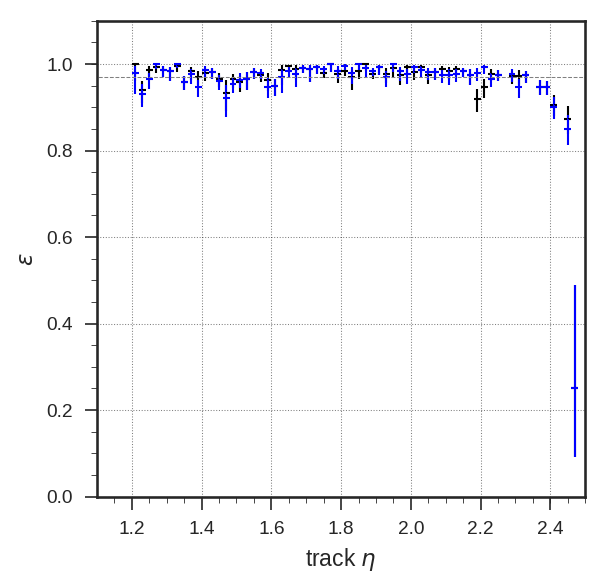

[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  46, 117, 143, 168, 153,
 119, 182, 197, 127, 170, 149, 169, 180,  76, 197, 168, 119, 166, 235, 135,
 175,  68, 182,  86, 230,  80, 140, 256, 102, 132, 253,  98, 134, 107, 304,
 133, 136, 106, 119, 129, 157, 151, 157, 155, 161, 121, 172, 241, 122, 148,
 149, 180, 245,   0, 176, 150, 192,   0, 231, 265, 181,   0, 127,   8,   0]
[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  45, 109, 138, 168, 151,
 117, 182, 189, 124, 161, 147, 166, 173,  70, 188, 162, 115, 163, 230, 128,
 166,  66, 179,  84, 228,  79, 139, 253, 102, 130, 252,  96, 134, 106, 299,
 132, 132, 106, 117, 126, 156, 149, 154, 152, 157, 118, 168, 237, 119, 145,
 148, 174, 239,   0, 172, 142, 187,   0, 219, 251, 163,   0, 108,   2,   0]
[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
    nan,    nan

In [54]:
# Efficiency vs eta
plt.figure()

nbinsx = 90
xlow = 0.7
xup = 2.5

eff_data_theta = eff_data[:, 5]  # index 5 is theta_median
eff_data_eta = np.apply_along_axis(theta_to_eta_f, 0, eff_data_theta)

pt_thresh = 20
gen_pt_thresh = 30
gen_passed = eff_data[:, 1] > gen_pt_thresh  # index 1 is true_pt
denom_hist, edges = np.histogram(eff_data_eta[gen_passed], bins=nbinsx, range=(xlow,xup))
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2

# Old efficiency
color = 'black'
old_denom_hist = [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  46, 117, 143, 168, 153,
 119, 182, 197, 127, 170, 149, 169, 180,  76, 197, 168, 119, 166, 235, 135,
 175,  68, 182,  86, 230,  80, 140, 256, 102, 132, 253,  98, 134, 107, 304,
 133, 136, 106, 119, 129, 157, 151, 157, 155, 161, 121, 172, 241, 122, 148,
 149, 180, 245,   0, 176, 150, 192,   0, 231, 265, 181,   0, 127,   8,   0]
old_num_hist = [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  46, 110, 141, 167, 151,
 117, 181, 189, 125, 165, 146, 166, 174,  71, 190, 161, 115, 163, 229, 130,
 166,  67, 181,  85, 228,  79, 139, 251, 102, 129, 249,  95, 132, 107, 297,
 132, 133, 105, 116, 128, 154, 150, 153, 152, 159, 119, 170, 237, 119, 136,
 141, 176, 239,   0, 171, 146, 187,   0, 219, 251, 164,   0, 111,   2,   0]
with np.errstate(divide='ignore', invalid='ignore'):
  old_eff_hist = np.true_divide(old_num_hist, old_denom_hist)
yerr = find_efficiency_errors(old_denom_hist, old_num_hist)
ydata = old_eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1, fmt='o')

# Efficiency for (L1 pT > 20 only && passed)
color = 'blue'
#passed = gen_passed & (eff_data[:, 3] > pt_thresh)  # index 3 is pt, index 4 is passed
passed = gen_passed & (eff_data[:, 3] > pt_thresh) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
with np.errstate(divide='ignore', invalid='ignore'):
  eff_hist = np.true_divide(num_hist, denom_hist)
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1, fmt='o')

plt.plot([xlow-0.5,xup+0.5], [0.97,0.97], ls='dashed', lw=0.5, color='gray')
#plt.xlim(xlow-0.5,xup+0.5)
plt.xlim(1.1,2.5)
plt.ylim(0,1.1)
plt.xlabel(r'track $\eta$')
plt.ylabel(r'$\epsilon$')
plt.show()

print np.array2string(denom_hist, separator=', ', precision=4, floatmode='fixed')
print np.array2string(num_hist, separator=', ', precision=4, floatmode='fixed')
print np.array2string(eff_hist, separator=', ', precision=4, floatmode='fixed')

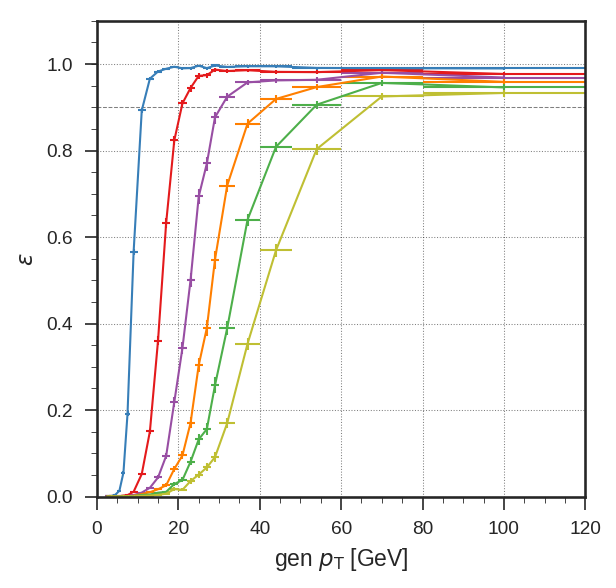

[INFO    ] Eff at 10/20/30/40/50/60 GeV: 0.892752314292, 0.909090909091, 0.924599434496, 0.919382504288, 0.906111603189, 0.925087108014


In [55]:
# Efficiency vs pT
plt.figure()

eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30., 34., 40., 48., 60., 80., 120.)

pt_list = (10., 20., 30., 40., 50., 60.)

if omtf_input:
  gen_passed = (0.8 <= eff_data_eta) & (eff_data_eta <= 1.24)
else:
  gen_passed = (1.24 <= eff_data_eta) & (eff_data_eta <= 2.4)

denom_hist, edges = np.histogram(eff_data[:, 1][gen_passed], bins=eff_pt_bins)  # index 1 is true_pt
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2

denom_hists = []
num_hists = []
eff_hists = []

for pt, color in zip(pt_list, my_palette):
  passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is true_pt
  with np.errstate(divide='ignore', invalid='ignore'):
    eff_hist = np.true_divide(num_hist, denom_hist)
  denom_hists.append(denom_hist)
  num_hists.append(num_hist)
  eff_hists.append(eff_hist)
  
  yerr = find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='gray')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'gen $p_{\mathrm{T}}$ [GeV]')
plt.ylabel(r'$\varepsilon$')
plt.show()

logger.info("Eff at 10/20/30/40/50/60 GeV: {0}, {1}, {2}, {3}, {4}, {5}".format(
    eff_hists[0][11], eff_hists[1][16], eff_hists[2][21], eff_hists[3][23], eff_hists[4][24], eff_hists[5][25]))

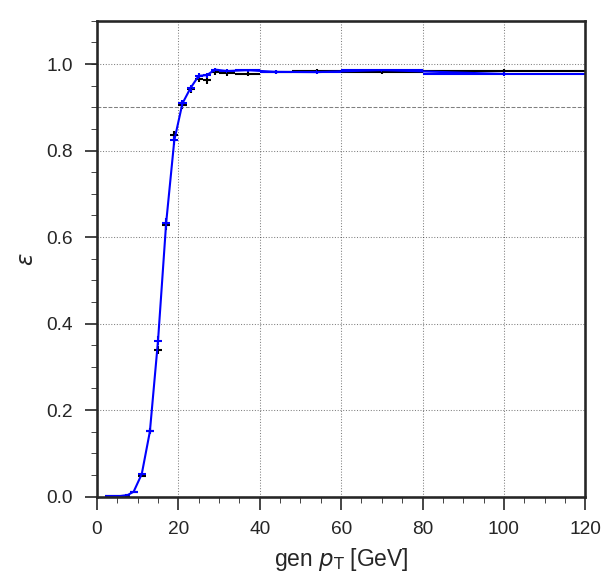

[    0,     0,     0,     0, 30006, 21830, 13460,  9076,  6371,  4725,
  6711,  4429,  3325,  2388,  1853,  1458,  1232,   980,   810,   744,
   626,  1061,  1206,  1166,  1129,  1148,  1094]
[   0,    0,    0,    0,    3,    4,    7,    7,   13,   15,   74,  230,
  500,  861, 1173, 1201, 1120,  926,  788,  725,  618, 1044, 1189, 1145,
 1108, 1132, 1069]
[       nan,        nan,        nan,        nan, 9.9980e-05, 1.8323e-04,
 5.2006e-04, 7.7126e-04, 2.0405e-03, 3.1746e-03, 1.1027e-02, 5.1930e-02,
 1.5038e-01, 3.6055e-01, 6.3303e-01, 8.2373e-01, 9.0909e-01, 9.4490e-01,
 9.7284e-01, 9.7446e-01, 9.8722e-01, 9.8398e-01, 9.8590e-01, 9.8199e-01,
 9.8140e-01, 9.8606e-01, 9.7715e-01]


In [56]:
# Efficiency vs pT
plt.figure()

# Old efficiency
color = 'black'
old_denom_hist = [    0,     0,     0,     0, 30006, 21830, 13460,  9076,  6371,  4725,
  6711,  4429,  3325,  2388,  1853,  1458,  1232,   980,   810,   744,
   626,  1061,  1206,  1166,  1129,  1148,  1094]
old_num_hist = [   0,    0,    0,    0,    3,    2,    6,    5,    5,    7,   70,  214,
  507,  808, 1164, 1219, 1116,  923,  783,  716,  615, 1038, 1179, 1145,
 1112, 1127, 1077]
with np.errstate(divide='ignore', invalid='ignore'):
  old_eff_hist = np.true_divide(old_num_hist, old_denom_hist)
yerr = find_efficiency_errors(old_denom_hist, old_num_hist)
ydata = old_eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1, fmt='o')

# Efficiency for (L1 pT > 20 only && passed)
color = 'blue'
with np.errstate(divide='ignore', invalid='ignore'):
  eff_hist = np.true_divide(num_hists[1], denom_hists[0])
yerr = find_efficiency_errors(denom_hists[1], num_hists[1])
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='gray')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'gen $p_{\mathrm{T}}$ [GeV]')
plt.ylabel(r'$\varepsilon$')
plt.show()

print np.array2string(denom_hists[1], separator=', ', precision=4, floatmode='fixed')
print np.array2string(num_hists[1], separator=', ', precision=4, floatmode='fixed')
print np.array2string(eff_hists[1], separator=', ', precision=4, floatmode='fixed')

In [57]:
# Find out pT scale factor
xmin = 0.
xmax = 60.
nbinsx = 120
xedges = np.linspace(xmin, xmax, num=nbinsx+1)  # edges used to digitize true_pt

nbinsy = 5  # j = zone0-1, zone2-4, zone5, zone6, all zones

# Each bin contains the threshold for ~90% probability for (zone_special, true_pt)
xxx = np.zeros((nbinsy,nbinsx), dtype=np.float32)

for j in xrange(nbinsy):
  if j == 0:
    sel_j = (0 <= eff_data[:,0]) & (eff_data[:,0] <= 1)
  elif j == 1:
    sel_j = (2 <= eff_data[:,0]) & (eff_data[:,0] <= 4)
  elif j == 2:
    sel_j = (eff_data[:,0] == 5)
  elif j == 3:
    sel_j = (eff_data[:,0] == 6)
  elif j == 4:
    sel_j = (eff_data[:,0] >= 0)

  xx = eff_data[:,1][sel_j]  # true_pt
  yy = eff_data[:,2][sel_j]  # xml_pt
  zz = eff_data[:,4][sel_j]  # discr_passed

  ind = np.digitize(xx, xedges[1:])  # split into mutually-exclusive true_pt bins

  for i in xrange(nbinsx):
    # >>> xedges[:5]
    # array([0. , 0.5, 1. , 1.5, 2. ])
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue

    if 0 <= xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 40:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size

    xx_i = xx[(i <= ind) & (ind <= i+step)]
    yy_i = yy[(i <= ind) & (ind <= i+step)]
    zz_i = zz[(i <= ind) & (ind <= i+step)]
    coverage = 90.
    coverage += 0.5 # inefficiency due to fiducial cuts
    #coverage += 1.0 # inefficiency due to fiducial cuts

    yz_i = np.where(zz_i==0, 0, yy_i)  # muons who passed
    if len(yz_i) < 100:  # not enough stats
      continue

    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    xxx[j,i] = pct

    # Debug
    if j == 4 and 14 <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)

14.0 0.0
14.5 0.0
15.0 0.0
15.5 0.0
16.0 0.0
16.5 0.0
17.0 0.0
17.5 0.0
18.0 0.0
18.5 0.0
19.0 0.118483412322
19.5 0.121951219512
20.0 0.192307692308
20.5 0.211267605634
21.0 0.218658892128
21.5 0.0748502994012
22.0 0.0804505229284
22.5 0.0
23.0 0.0
23.5 0.0
24.0 0.0
24.5 0.0564334085779
25.0 0.0590667454223
25.5 0.0600600600601
26.0 0.0623441396509
26.5 0.0635727908455
27.0 0.0
27.5 0.0692520775623
28.0 0.0716332378223
28.5 0.0734753857458
29.0 0.0768639508071
29.5 0.0788022064618
30.0 0.0796178343949


[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

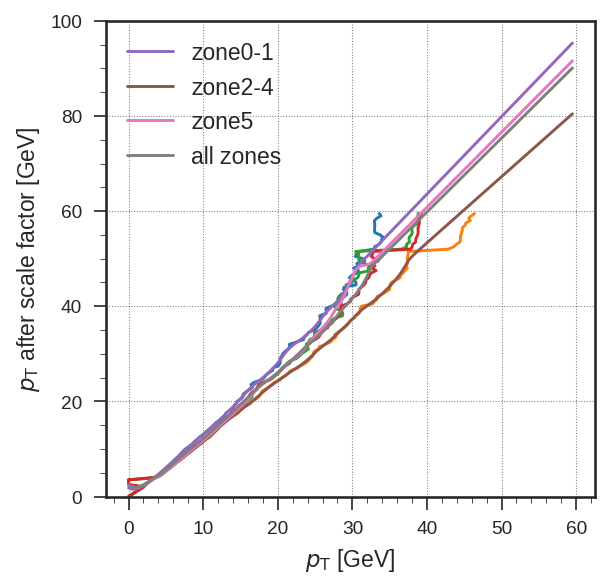

In [58]:
# Find out pT scale factor
plt.figure()

# Before smoothing
xdata = xedges[:-1]
if omtf_input:
  #plt.plot(xxx[0], xdata)
  #plt.plot(xxx[1], xdata)
  #plt.plot(xxx[2], xdata)
  plt.plot(xxx[3], xdata)
  plt.plot(xxx[4], xdata)
else:
  plt.plot(xxx[0], xdata)
  plt.plot(xxx[1], xdata)
  plt.plot(xxx[2], xdata)
  #plt.plot(xxx[3], xdata)
  plt.plot(xxx[4], xdata)
plt.xlabel(r'$p_{\mathrm{T}}$ [GeV]')
plt.ylabel(r'$p_{\mathrm{T}}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf4 = Rbf(xxx[4,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')

# After smoothing
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)
ydata4 = rbf4(xdata)

if omtf_input:
  #line0, = plt.plot(xdata, ydata0)
  #line1, = plt.plot(xdata, ydata1)
  #line2, = plt.plot(xdata, ydata2)
  line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line3, line4), ('zone6', 'all zones'), loc='upper left')
else:
  line0, = plt.plot(xdata, ydata0)
  line1, = plt.plot(xdata, ydata1)
  line2, = plt.plot(xdata, ydata2)
  #line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line0, line1, line2, line4), ('zone0-1', 'zone2-4', 'zone5', 'all zones'), loc='upper left')

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata4, separator=', ', precision=4, floatmode='fixed')

def monotonically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
assert(monotonically_increasing(ydata4[4:]))

plt.ylim(0,100)
plt.show()

In [59]:
# Rates
rates_jobid_offset = 159 - 30
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for jevt, (x, x_mask, x_road, y_pred, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_x_road_test, pu_y_test_pred_regr, pu_y_test_pred_discr, pu_aux_test)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, phi_median, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  #xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(y_pred)
  #true_pt = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  highest_part_pt = highest_part_pt if highest_part_pt > 0 else np.nan
  highest_track_pt = highest_track_pt if highest_track_pt > 0 else np.nan
  
  trk_eta = theta_to_eta_f(theta_median)
  if omtf_input:
    trk_eta_ok = (0.8 <= trk_eta <= 1.24)
  else:
    trk_eta_ok = (1.24 <= trk_eta <= 2.4)
  
  if jobid < (rates_njobs-1):
    if passed and trk_eta_ok:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and trk_eta_ok:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  if passed and highest_part_pt < 14 and pt > 40.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt),
    print "{0} {1} {2}".format(ndof, pt, y_discr)
    if pt > 100.:  # why?
      with np_printoptions(precision=3, suppress=True):
        if omtf_input:
          nlayers1 = 9
        else:
          nlayers1 = 12
        for lay in xrange(nlayers1):
          if omtf_input:
            tmp = np.arange(2) * nlayers1 + lay
          else:
            if 0 <= lay <= 4:
              tmp = np.array([0 * nlayers1, 1 * nlayers1, 2 * nlayers1, 2 * nlayers1 + 6]) + lay
            elif lay == 11:
              tmp = np.array([0 * nlayers1, 1 * nlayers1, 2 * nlayers1 - 6, 2 * nlayers1]) + lay
            else:
              tmp = np.arange(2) * nlayers1 + lay
          print "....", lay, x[tmp]

  31 2937 11.6057 18.0000 7 [52.93944771] [1.]
  33 7731  6.2690 28.5000 6 [80.75430545] [1.]
  34  834 11.9378 21.0000 7 [44.89085087] [1.]
  34 3461  1.3885  8.0000 6 [61.49034474] [1.]
  40 2186  7.5850 30.5000 4 [111.37506704] [1.]
.... 0 [-60.  42. -15.   6.]
.... 1 [0. 0. 0. 0.]
.... 2 [ 0. 42. -1.  6.]
.... 3 [0. 0. 0. 0.]
.... 4 [18. 41.  0. -6.]
.... 5 [0. 0.]
.... 6 [0. 0.]
.... 7 [0. 0.]
.... 8 [0. 0.]
.... 9 [0. 0.]
.... 10 [ 2. 40.]
.... 11 [0. 0. 0. 0.]
  40 2828  2.7300  3.5000 4 [41.63560352] [1.]
  42 3298  1.9904     nan 5 [71.10989359] [1.]
  42 4409  3.8925     nan 6 [131.51959751] [1.]
.... 0 [0. 0. 0. 0.]
.... 1 [0. 0. 0. 0.]
.... 2 [19.  8. -2. -6.]
.... 3 [3. 8. 1. 5.]
.... 4 [-1.  8.  0.  5.]
.... 5 [0. 0.]
.... 6 [0. 0.]
.... 7 [0. 8.]
.... 8 [2. 9.]
.... 9 [0. 0.]
.... 10 [0. 0.]
.... 11 [-4. 17. -8.  4.]
  42 4785  3.1541     nan 3 [65.53921887] [1.]
  42 7173  9.9925 50.0000 5 [82.34252778] [1.]
  43 7563  3.6020 29.0000 4 [48.74199452] [1.]
  47 3847  3.26

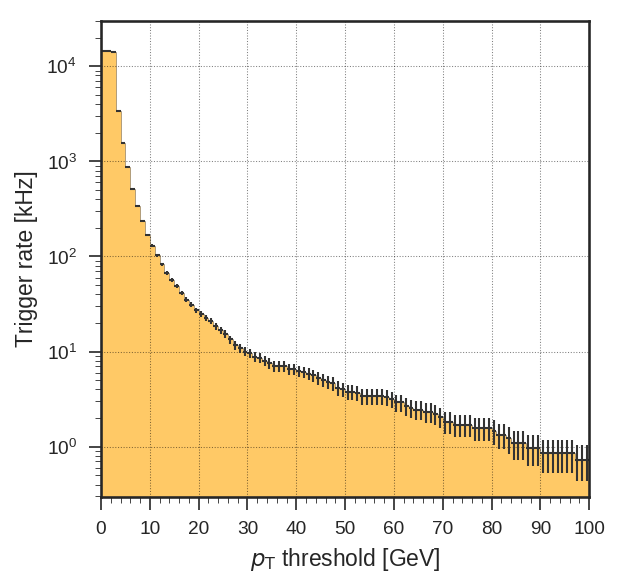

[INFO    ] nevents: 258400/498400
[INFO    ] Rates at 18/20/22/25/30 GeV: 31.1632581651, 25.0528152883, 21.1421318948, 15.3983157575, 9.65449956059


[1.4327e+04, 1.4327e+04, 1.4164e+04, 3.3639e+03, 1.5489e+03, 8.7306e+02,
 5.0961e+02, 3.3607e+02, 2.3452e+02, 1.6914e+02, 1.3015e+02, 1.0327e+02,
 8.2613e+01, 6.6848e+01, 5.6827e+01, 4.9250e+01, 4.1184e+01, 3.5074e+01,
 3.1163e+01, 2.7253e+01, 2.5053e+01, 2.2609e+01, 2.1142e+01, 1.8454e+01,
 1.6865e+01, 1.5398e+01, 1.3443e+01, 1.1610e+01, 1.0877e+01, 1.0021e+01,
 9.6545e+00, 8.7990e+00, 8.5546e+00, 8.0658e+00, 7.5769e+00, 7.0881e+00,
 7.0881e+00, 7.0881e+00, 6.5993e+00, 6.5993e+00, 6.2327e+00, 6.1104e+00,
 5.8660e+00, 5.6216e+00, 5.2550e+00, 5.0106e+00, 4.7661e+00, 4.6439e+00,
 4.1551e+00, 4.0329e+00, 3.7885e+00, 3.7885e+00, 3.6663e+00, 3.4218e+00,
 3.4218e+00, 3.4218e+00, 3.4218e+00, 3.4218e+00, 3.2996e+00, 3.1774e+00,
 2.9330e+00, 2.9330e+00, 2.6886e+00, 2.5664e+00, 2.4442e+00, 2.4442e+00,
 2.3220e+00, 2.3220e+00, 2.1998e+00, 2.0776e+00, 1.8331e+00, 1.8331e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.5887e+00, 1.5887e+00,
 1.5887e+00, 1.5887e+00, 1.4665e+00, 1.3443e+00, 1.

In [60]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808  # assume lumi=8e34, PU=200, xsec_pp=80mb
  nZeroBiasEvents = float(nevents)
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > 1e-7]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(0.3,3e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be approx half the statistics
logger.info("Rates at 18/20/22/25/30 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[20], hist[22], hist[25], hist[30]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

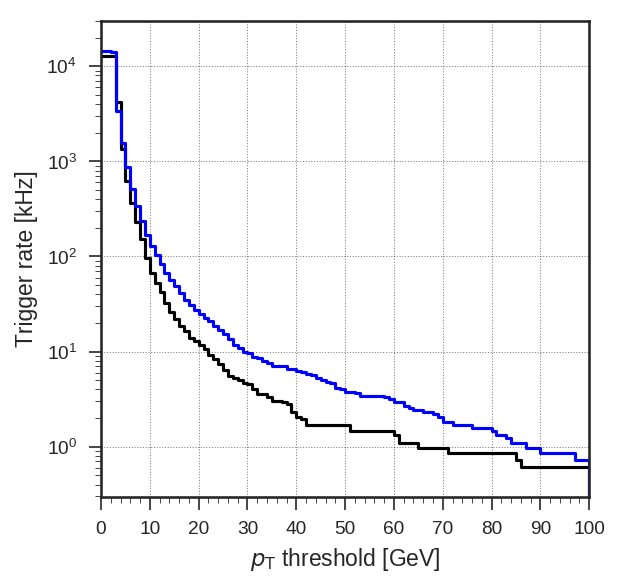

In [61]:
# Old rates
old_hist = [1.2879e+04, 1.2879e+04, 1.2879e+04, 4.2422e+03, 1.3642e+03, 6.1605e+02,
 3.6455e+02, 2.3159e+02, 1.5411e+02, 9.5812e+01, 6.6970e+01, 5.2672e+01,
 4.2162e+01, 3.2752e+01, 2.6397e+01, 2.1998e+01, 1.8820e+01, 1.6376e+01,
 1.4054e+01, 1.2954e+01, 1.1854e+01, 1.0632e+01, 9.1657e+00, 8.3102e+00,
 7.3325e+00, 6.4771e+00, 5.4994e+00, 5.2550e+00, 5.0106e+00, 4.6439e+00,
 4.5217e+00, 4.0329e+00, 3.5441e+00, 3.5441e+00, 3.2996e+00, 3.0552e+00,
 3.0552e+00, 2.9330e+00, 2.8108e+00, 2.3220e+00, 2.0776e+00, 1.9553e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.3443e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 8.5546e-01,
 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01,
 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01,
 8.5546e-01, 7.3325e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
steps = np.append(np.array(old_hist), 0.)
plt.step(edges, steps, where='post', color='k', lw=1.5)
steps = np.append(np.array(hist), 0.)
plt.step(edges, steps, where='post', color='blue', lw=1.5)
plt.xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(0.3,3e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

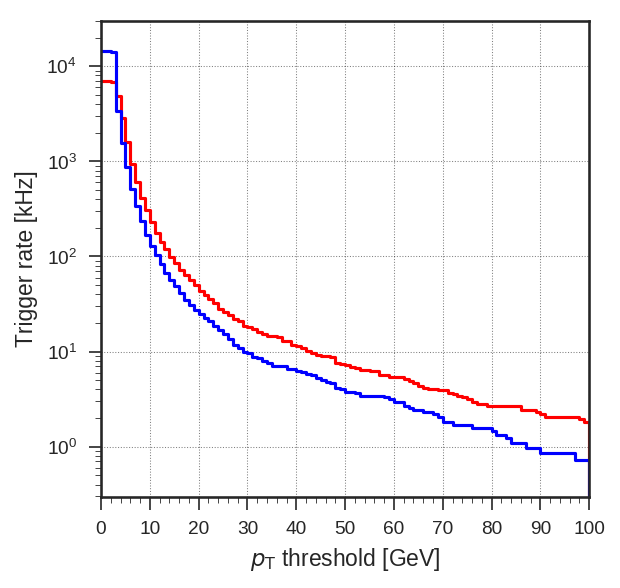

In [62]:
# Reference EMTF rates
old_hist = [7.0348e+03, 7.0348e+03, 6.7679e+03, 4.9052e+03, 2.8801e+03, 1.5997e+03,
 9.3649e+02, 6.0726e+02, 4.1551e+02, 3.0552e+02, 2.2865e+02, 1.7781e+02,
 1.4237e+02, 1.1940e+02, 9.9600e+01, 8.4569e+01, 7.1859e+01, 6.3182e+01,
 5.6338e+01, 4.9617e+01, 4.3262e+01, 3.9473e+01, 3.5929e+01, 3.2141e+01,
 2.8352e+01, 2.6153e+01, 2.4197e+01, 2.2242e+01, 2.0776e+01, 1.8820e+01,
 1.8209e+01, 1.7231e+01, 1.6254e+01, 1.5154e+01, 1.4665e+01, 1.4543e+01,
 1.4176e+01, 1.3076e+01, 1.2832e+01, 1.1854e+01, 1.1365e+01, 1.0999e+01,
 1.0143e+01, 9.7767e+00, 9.2879e+00, 9.0435e+00, 8.9212e+00, 8.6768e+00,
 7.5769e+00, 7.3325e+00, 7.2103e+00, 6.8437e+00, 6.7215e+00, 6.3549e+00,
 6.3549e+00, 6.2327e+00, 6.2327e+00, 5.7438e+00, 5.7438e+00, 5.3772e+00,
 5.3772e+00, 5.3772e+00, 5.1328e+00, 4.8884e+00, 4.6439e+00, 4.3995e+00,
 4.1551e+00, 4.0329e+00, 4.0329e+00, 3.9107e+00, 3.9107e+00, 3.6663e+00,
 3.5441e+00, 3.4218e+00, 3.2996e+00, 3.1774e+00, 2.9330e+00, 2.8108e+00,
 2.8108e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00,
 2.6886e+00, 2.6886e+00, 2.4442e+00, 2.4442e+00, 2.4442e+00, 2.3220e+00,
 2.1998e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00,
 2.0776e+00, 2.0776e+00, 1.9553e+00, 1.8331e+00]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
steps = np.append(np.array(old_hist), 0.)
plt.step(edges, steps, where='post', color='red', lw=1.5)
steps = np.append(np.array(hist), 0.)
plt.step(edges, steps, where='post', color='blue', lw=1.5)
plt.xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(0.3,3e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

### Efficiency & Rates &ndash; displaced muons

In [63]:
# Rates
rates_jobid_offset = 159 - 30
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for jevt, (x, x_mask, x_road, y_pred, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_x_road_test, pu_d1_test_pred_regr, pu_d0_test_pred_regr, pu_aux_test)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, phi_median, theta_median = x_road
  
  #passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  #xml_pt = np.abs(1.0/y_pred)
  #pt = mytrigger.get_trigger_pt(y_pred)
  #true_pt = np.abs(1.0/y_true)
  
  passed = (np.abs(1.0/y_pred) > 6) & (np.abs(y_discr) > 10)  #FIXME
  pt = np.abs(1.0/y_pred)  #FIXME
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  highest_part_pt = highest_part_pt if highest_part_pt > 0 else np.nan
  highest_track_pt = highest_track_pt if highest_track_pt > 0 else np.nan
  
  trk_eta = theta_to_eta_f(theta_median)
  if omtf_input:
    trk_eta_ok = (0.8 <= trk_eta <= 1.24)
  else:
    trk_eta_ok = (1.24 <= trk_eta <= 2.4)
  
  trk_eta_ok = True  #FIXME
  
  if jobid < (rates_njobs-1):
    if passed and trk_eta_ok:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and trk_eta_ok:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  if passed and highest_part_pt < 14 and pt > 40.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt),
    print "{0} {1} {2}".format(ndof, pt, y_discr)
    if pt > 100.:  # why?
      with np_printoptions(precision=3, suppress=True):
        if omtf_input:
          nlayers1 = 9
        else:
          nlayers1 = 12
        for lay in xrange(nlayers1):
          if omtf_input:
            tmp = np.arange(2) * nlayers1 + lay
          else:
            if 0 <= lay <= 4:
              tmp = np.array([0 * nlayers1, 1 * nlayers1, 2 * nlayers1, 2 * nlayers1 + 6]) + lay
            elif lay == 11:
              tmp = np.array([0 * nlayers1, 1 * nlayers1, 2 * nlayers1 - 6, 2 * nlayers1]) + lay
            else:
              tmp = np.arange(2) * nlayers1 + lay
          print "....", lay, x[tmp]

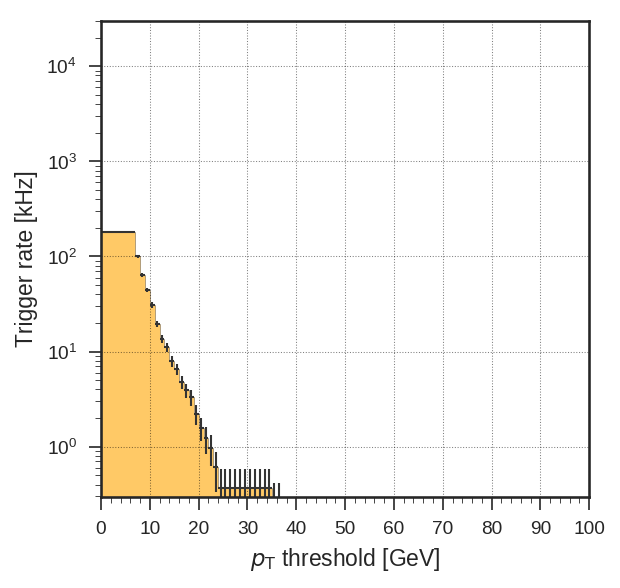

[INFO    ] nevents: 258400/498400
[INFO    ] Rates at 18/20/22/25/30 GeV: 3.29963914305, 1.5887151137, 0.977670840919, 0.366626568139, 0.366626568139


[1.8234e+02, 1.8234e+02, 1.8234e+02, 1.8234e+02, 1.8234e+02, 1.8234e+02,
 1.8234e+02, 1.0046e+02, 6.4282e+01, 4.4240e+01, 3.1041e+01, 1.9553e+01,
 1.3687e+01, 1.1121e+01, 7.9436e+00, 6.5993e+00, 4.7661e+00, 3.9107e+00,
 3.2996e+00, 2.1998e+00, 1.5887e+00, 1.2221e+00, 9.7767e-01, 6.1104e-01,
 3.6663e-01, 3.6663e-01, 3.6663e-01, 3.6663e-01, 3.6663e-01, 3.6663e-01,
 3.6663e-01, 3.6663e-01, 3.6663e-01, 3.6663e-01, 3.6663e-01, 2.4442e-01,
 2.4442e-01, 1.2221e-01, 1.2221e-01, 1.2221e-01, 1.2221e-01, 1.2221e-01,
 1.2221e-01, 1.2221e-01, 1.2221e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.

In [64]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808  # assume lumi=8e34, PU=200, xsec_pp=80mb
  nZeroBiasEvents = float(nevents)
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > 1e-7]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(0.3,3e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be approx half the statistics
logger.info("Rates at 18/20/22/25/30 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[20], hist[22], hist[25], hist[30]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

In [65]:
from numba import njit

gold_pt = 60
gold_d0 = 20
triggers_pt = np.linspace(0, 60, num=12+1)
triggers_d0 = np.linspace(0, 20, num=8+1)

class TriggerMetrics(object):
  """Abstract trigger metrics base class"""

  def __init__(self):
    self.gold_pt = gold_pt
    self.gold_d0 = gold_d0
    self.gold = lambda y_true, dxy_true: (np.abs(1.0/y_true) > self.gold_pt) & (np.abs(dxy_true) > self.gold_d0)
    self.triggers_pt = triggers_pt
    self.triggers_d0 = triggers_d0
    self.trig = lambda y_pred, dxy_pred, trig_pt, trig_d0: (np.abs(1.0/y_pred) > trig_pt) & (np.abs(dxy_pred) > trig_d0)

  def get_metrics(self, y_true, y_pred, dxy_true, dxy_pred, aux=None):
    raise NotImplementedError

def patt_recog_eff():
  eff = 0.87
  return eff

class EffMetrics(TriggerMetrics):
  def __init__(self):
    super(EffMetrics, self).__init__()
    return

  def get_metrics(self, y_true, y_pred, dxy_true, dxy_pred, aux=None):  # override
    sel_denom = self.gold(y_true, dxy_true)
    denom = sel_denom.sum()

    # Loop over triggers
    xv, yv = np.meshgrid(self.triggers_pt, self.triggers_d0)
    metrics = np.zeros(xv.shape, dtype=np.float32)
    for i in xrange(metrics.shape[0]):
      for j in xrange(metrics.shape[1]):
        trig_pt = xv[i,j]
        trig_d0 = yv[i,j]
        sel_numer = self.trig(y_pred, dxy_pred, trig_pt, trig_d0)
        numer = (sel_denom & sel_numer).sum()

        # Calculate metric
        eff = np.true_divide(numer, denom) * 100
        metrics[i,j] = eff

    w = patt_recog_eff()
    metrics *= w
    return metrics

@njit
def jitted_get_sel_by_event(sel, event_id, sel_by_event):
  for i in xrange(sel.shape[0]):
    sel_by_event[event_id[i]] |= sel[i]

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808  # assume lumi=8e34, PU=200, xsec_pp=80mb
  nZeroBiasEvents = float(nevents)
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

class RatesMetrics(TriggerMetrics):
  def __init__(self):
    super(RatesMetrics, self).__init__()
    return

  def get_metrics(self, y_true, y_pred, dxy_true, dxy_pred, aux=None):  # override
    rates_njobs_all = 63
    rates_njobs = 63 - 30  # only half the statistics used for testing
    rates_nevents_per_job = 8000
    rates_nevents_last_job = 2400
    rates_nevents_all = 498400
    rates_nevents = 258400  # only half the statistics used for testing
    assert(rates_nevents_all == (rates_njobs_all-1)*rates_nevents_per_job + rates_nevents_last_job)
    assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

    #rates_jobid_offset = 159 - 30
    rates_jobid_offset = 159
    assert(aux is not None)
    (jobid, ievt) = aux[..., 0].astype(np.int32), aux[..., 1].astype(np.int32)
    event_id = ((jobid - rates_jobid_offset) * rates_nevents_per_job) + ievt
    assert((0 <= event_id.min()) and (event_id.max() <= rates_nevents))
    def monotonically_increasing(a):
      return np.all(a[1:] >= a[:-1], axis=-1)
    assert(monotonically_increasing(event_id))

    # Loop over triggers
    xv, yv = np.meshgrid(self.triggers_pt, self.triggers_d0)
    metrics = np.zeros(xv.shape, dtype=np.float32)
    for i in xrange(metrics.shape[0]):
      for j in xrange(metrics.shape[1]):
        trig_pt = xv[i,j]
        trig_d0 = yv[i,j]
        sel = self.trig(y_pred, dxy_pred, trig_pt, trig_d0)

        # Calculate metric
        sel = np.squeeze(sel)
        sel_by_event = np.zeros(rates_nevents, dtype=np.bool)
        jitted_get_sel_by_event(sel, event_id, sel_by_event)
        rate = sel_by_event.sum()
        metrics[i,j] = rate

    w = conversion_to_kHz(rates_nevents)
    metrics *= w
    return metrics

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-numba/0.39.0-ikaegh2/lib/python2.7/site-packages/numba/__init__.py:78: UserWarning: llvmlite version format not recognized!
  warnings.warn("llvmlite version format not recognized!")


In [66]:
# Find efficiency matrix

eff_metrics = EffMetrics().get_metrics(y_true=d1_test_true, y_pred=d1_test_pred_regr, dxy_true=d0_test_true, dxy_pred=d0_test_pred_regr)

metrics = eff_metrics
for i in xrange(metrics.shape[0]):
  for j in xrange(metrics.shape[1]):
    print triggers_pt[j], triggers_d0[i], metrics[i,j]

0.0 0.0 86.93399
5.0 0.0 76.46055
10.0 0.0 53.643402
15.0 0.0 39.913506
20.0 0.0 28.713959
25.0 0.0 18.152504
30.0 0.0 10.935508
35.0 0.0 5.808801
40.0 0.0 3.1244311
45.0 0.0 1.8042488
50.0 0.0 1.23217
55.0 0.0 0.77010626
60.0 0.0 0.48406675
0.0 2.5 86.64795
5.0 2.5 76.46055
10.0 2.5 53.643402
15.0 2.5 39.913506
20.0 2.5 28.713959
25.0 2.5 18.152504
30.0 2.5 10.935508
35.0 2.5 5.808801
40.0 2.5 3.1244311
45.0 2.5 1.8042488
50.0 2.5 1.23217
55.0 2.5 0.77010626
60.0 2.5 0.48406675
0.0 5.0 86.53794
5.0 5.0 76.438545
10.0 5.0 53.621395
15.0 5.0 39.913506
20.0 5.0 28.713959
25.0 5.0 18.152504
30.0 5.0 10.935508
35.0 5.0 5.808801
40.0 5.0 3.1244311
45.0 5.0 1.8042488
50.0 5.0 1.23217
55.0 5.0 0.77010626
60.0 5.0 0.48406675
0.0 7.5 86.16389
5.0 7.5 76.306526
10.0 7.5 53.555386
15.0 7.5 39.8695
20.0 7.5 28.713959
25.0 7.5 18.152504
30.0 7.5 10.935508
35.0 7.5 5.808801
40.0 7.5 3.1244311
45.0 7.5 1.8042488
50.0 7.5 1.23217
55.0 7.5 0.77010626
60.0 7.5 0.48406675
0.0 10.0 85.70182
5.0 10.0 76.10

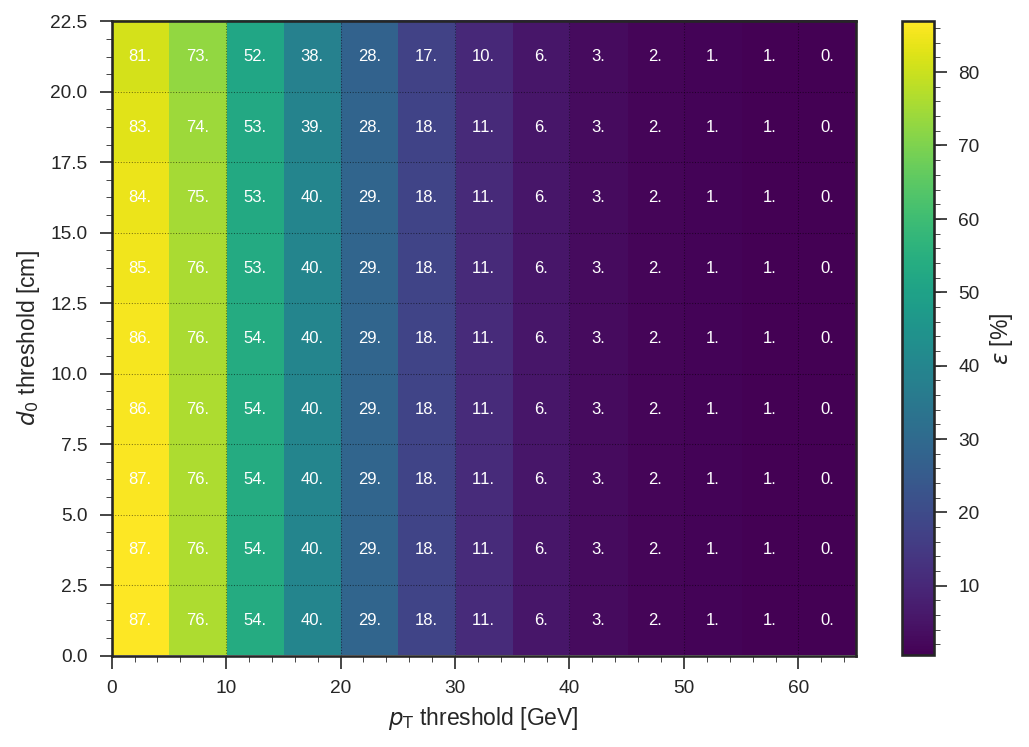

In [67]:
# Find efficiency matrix
fig, ax = plt.subplots(figsize=(8,5.6))

get_xstep = lambda x: x[1] - x[0]
xedges_tmp = triggers_pt
yedges_tmp = triggers_d0
xstep = get_xstep(xedges_tmp)
ystep = get_xstep(yedges_tmp)
xedges = np.append(xedges_tmp, xedges_tmp[-1] + xstep)
yedges = np.append(yedges_tmp, yedges_tmp[-1] + ystep)

xv, yv = np.meshgrid(xedges_tmp, yedges_tmp)
x = xv.ravel() + 0.5*xstep
y = yv.ravel() + 0.5*ystep
#z = metrics.T.ravel()
z = metrics.ravel()

h, xedges, yedges, image = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=my_cmap)
ax.set_xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
ax.set_ylabel(r'$d_{0}$ threshold [cm]')
cb = plt.colorbar(image)
cb.set_label(r'$\varepsilon$ [%]')

for i in xrange(metrics.shape[0]):
  for j in xrange(metrics.shape[1]):
    ax.text(xedges[j]+0.5*xstep, yedges[i]+0.5*ystep, np.array2string(metrics[i,j], precision=0),
            fontsize=8, color='w', ha='center', va='center')

plt.show()

In [68]:
# Find rates matrix

rates_metrics = RatesMetrics().get_metrics(y_true=None, y_pred=pu_d1_test_pred_regr, dxy_true=None, dxy_pred=pu_d0_test_pred_regr, aux=pu_aux_test)

metrics = rates_metrics
for i in xrange(metrics.shape[0]):
  for j in xrange(metrics.shape[1]):
    print triggers_pt[j], triggers_d0[i], metrics[i,j]

0.0 0.0 14316.768
5.0 0.0 755.73956
10.0 0.0 65.25953
15.0 0.0 14.90948
20.0 0.0 5.3771896
25.0 0.0 2.3219683
30.0 0.0 1.4665062
35.0 0.0 0.7332531
40.0 0.0 0.48883542
45.0 0.0 0.24441771
50.0 0.0 0.122208856
55.0 0.0 0.122208856
60.0 0.0 0.122208856
0.0 2.5 6817.9097
5.0 2.5 740.34125
10.0 2.5 64.64848
15.0 2.5 14.7872715
20.0 2.5 5.3771896
25.0 2.5 2.3219683
30.0 2.5 1.4665062
35.0 2.5 0.7332531
40.0 2.5 0.48883542
45.0 2.5 0.24441771
50.0 2.5 0.122208856
55.0 2.5 0.122208856
60.0 2.5 0.122208856
0.0 5.0 5603.3984
5.0 5.0 644.1629
10.0 5.0 53.771896
15.0 5.0 11.365423
20.0 5.0 4.032892
25.0 5.0 1.9553417
30.0 5.0 1.2220886
35.0 5.0 0.7332531
40.0 5.0 0.48883542
45.0 5.0 0.24441771
50.0 5.0 0.122208856
55.0 5.0 0.122208856
60.0 5.0 0.122208856
0.0 7.5 4379.721
5.0 7.5 484.4359
10.0 7.5 40.45113
15.0 7.5 8.187993
20.0 7.5 2.3219683
25.0 7.5 0.97767085
30.0 7.5 0.7332531
35.0 7.5 0.48883542
40.0 7.5 0.24441771
45.0 7.5 0.122208856
50.0 7.5 0.122208856
55.0 7.5 0.122208856
60.0 7.5 0.122

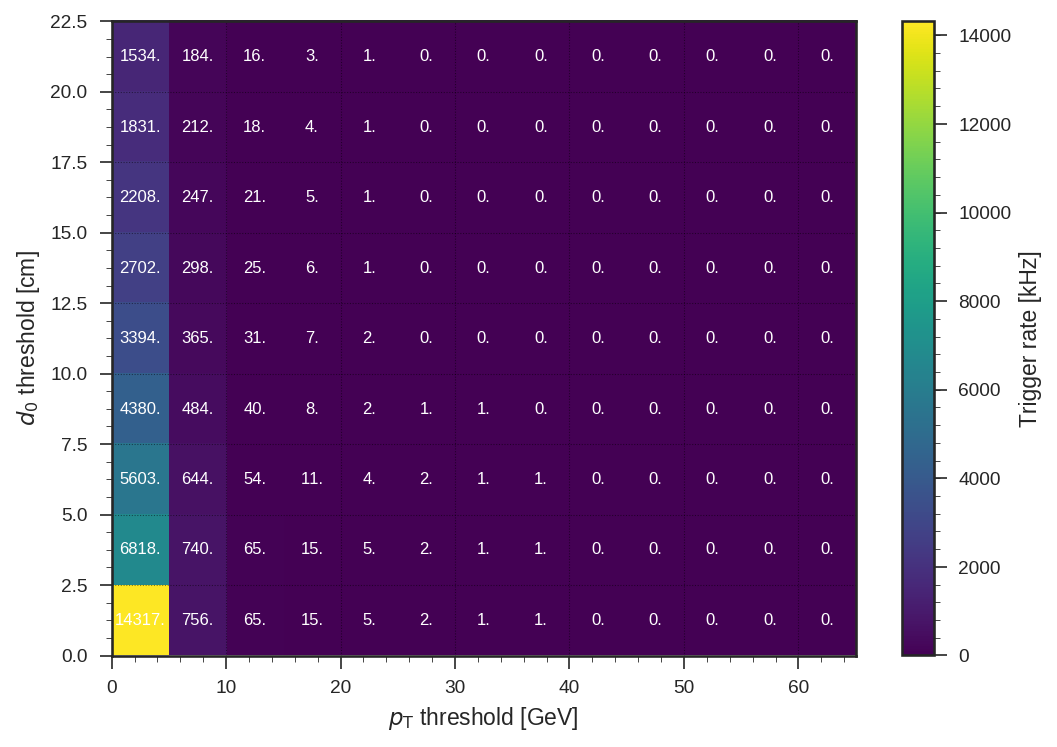

In [69]:
# Find rates matrix
fig, ax = plt.subplots(figsize=(8,5.6))

get_xstep = lambda x: x[1] - x[0]
xedges_tmp = triggers_pt
yedges_tmp = triggers_d0
xstep = get_xstep(xedges_tmp)
ystep = get_xstep(yedges_tmp)
xedges = np.append(xedges_tmp, xedges_tmp[-1] + xstep)
yedges = np.append(yedges_tmp, yedges_tmp[-1] + ystep)

xv, yv = np.meshgrid(xedges_tmp, yedges_tmp)
x = xv.ravel() + 0.5*xstep
y = yv.ravel() + 0.5*ystep
#z = metrics.T.ravel()
z = metrics.ravel()

h, xedges, yedges, image = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=my_cmap)
ax.set_xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
ax.set_ylabel(r'$d_{0}$ threshold [cm]')
cb = plt.colorbar(image)
cb.set_label(r'Trigger rate [kHz]')

for i in xrange(metrics.shape[0]):
  for j in xrange(metrics.shape[1]):
    ax.text(xedges[j]+0.5*xstep, yedges[i]+0.5*ystep, np.array2string(metrics[i,j], precision=0),
            fontsize=8, color='w', ha='center', va='center')

plt.show()

In [70]:
if True:
  triggers_pt = np.linspace(0, 60, num=40+1)  # more bins
  triggers_d0 = np.linspace(0, 20, num=40+1)  # more bins
  rates_metrics = RatesMetrics().get_metrics(y_true=None, y_pred=pu_d1_test_pred_regr, dxy_true=None, dxy_pred=pu_d0_test_pred_regr, aux=pu_aux_test)
  eff_metrics = EffMetrics().get_metrics(y_true=d1_test_true, y_pred=d1_test_pred_regr, dxy_true=d0_test_true, dxy_pred=d0_test_pred_regr)

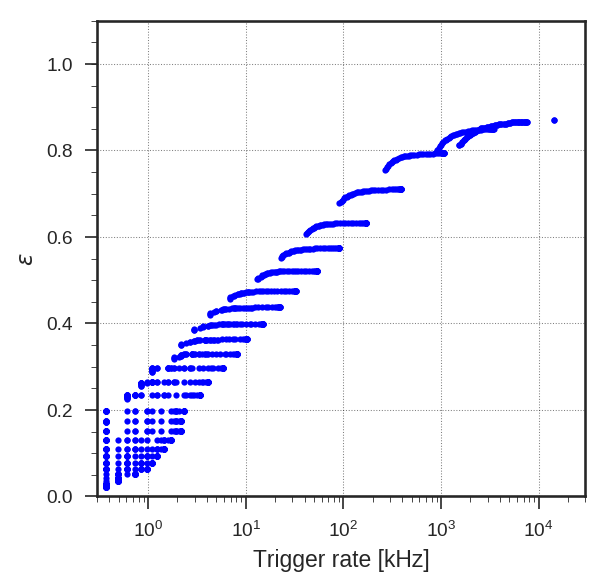

In [71]:
plt.figure()
plt.plot(rates_metrics.ravel(), eff_metrics.ravel()/100, 'bo', markersize=3)
plt.xlabel(r'Trigger rate [kHz]')
plt.ylabel(r'$\varepsilon$')
plt.xlim(0.3,3e4)
plt.ylim(0,1.1)
plt.xscale('log')
plt.show()